# Unit Testing of Phosphosite-Mapping Module

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotnine as p9
from IPython.display import display, clear_output

## Set-up Modules

Naive `NodesSitesMapping` and embedding approach `NodesSitesMapping_embedding` copy-pasted from 'bionetwork.py'.

`CumsumMapping` copy-pasted from 'bionetwork.py' and `soft_index` copy-pasted from 'train.py'. `add_hooks` is a helper function to add hooks to a model in order to visualize the gradients of the model. 

In [2]:
class NodesSitesMapping(nn.Module):
    """Layer to map signaling nodes to phosphosites with sparse connectivity.
       The connectivity is defined by nodes_sites_map, a binary (0/1) DataFrame of shape (n_sites, n_nodes).
       Only the connections indicated by 1 are learnable; we store these as a 1D parameter vector.
    """
    def __init__(self, nodes_sites_map: pd.DataFrame, hidden_layers: dict = None, dtype: torch.dtype = torch.float32, device: str = 'cpu', use_phospho: bool = True):
        """
        Parameters
        ----------
        nodes_sites_map : pd.DataFrame
            DataFrame with sites as rows and signaling nodes as columns.
            It must be one-hot (or sparse instead of dense) where 1 indicates a connection.
        dtype : torch.dtype, optional
            Data type for tensors.
        device : str, optional
            "cpu" or "cuda", by default "cpu".
        use_phospho : bool, optional
            Whether to use the phospho-specific weights, by default True.
        """
        super().__init__()
        self.device = device
        self.dtype = dtype

        # Convert mapping to a tensor and create the boolean mask
        mapping_tensor = torch.tensor(nodes_sites_map.values, dtype=self.dtype, device=self.device)
        self.mask = mapping_tensor != 0  # True where connection exists; shape: (n_sites, n_nodes)
        
        input_dim = nodes_sites_map.shape[1]  # Number of nodes
        output_dim = nodes_sites_map.shape[0]  # Number of sites

        layers = []
        prev_dim = input_dim
        
        # Add hidden layers if specified - Not used
        if hidden_layers:
            for i in range(1, len(hidden_layers) + 1):
                layers.append(nn.Linear(prev_dim, hidden_layers[i]).to(device, dtype))
                layers.append(nn.ReLU())
                prev_dim = hidden_layers[i]
        
        # Learnable parameter vector for the allowed weights (nonzero in the mask) and a bias parameter for each output
        n_nonzero = int(self.mask.sum().item())
        # Save the indices (row, col) where the mapping is 1
        self.indices = self.mask.nonzero(as_tuple=False)  # shape: (n_nonzero, 2)
        
        # Create a learnable vector for allowed connections
        if use_phospho:
            self.real_weights = nn.Parameter(torch.randn(n_nonzero, dtype=self.dtype, device=self.device)+1)
            self.bias = nn.Parameter(torch.zeros(output_dim, dtype=self.dtype, device=self.device))
        else:
            # Register as a buffer so it’s not trainable; it will remain ones
            self.registerBuffer('real_weights', torch.ones(n_nonzero, dtype=self.dtype, device=self.device))
            self.registerBuffer('bias', torch.zeros(output_dim, dtype=self.dtype, device=self.device))
        
        self.output_dim = output_dim

    def forward(self, Y_full: torch.Tensor):
        """
        Forward pass to map signaling nodes to phosphosites.
    
        Parameters
        ----------
        Y_full : torch.Tensor
            The signaling network output tensor. Shape (samples, time_points, n_nodes).
    
        Returns
        -------
        Y_mapped : torch.Tensor
            The mapped output tensor. Shape (samples, time_points, n_sites).
        """
        samples, time_points, nodes = Y_full.shape
        
        Y_full_reshaped = Y_full.view(samples * time_points, nodes)
        
        # Create a full weight matrix of shape (output_dim, n_nodes) filled with zeros
        full_weight = torch.zeros((self.output_dim, nodes), dtype=self.dtype, device=self.device)
        # Fill the allowed entries with the learnable weights
        full_weight[self.indices[:, 0], self.indices[:, 1]] = self.real_weights
        self.full_weight = full_weight
        Y_mapped_reshaped = torch.nn.functional.linear(Y_full_reshaped, full_weight, self.bias)
        Y_mapped = Y_mapped_reshaped.view(samples, time_points, -1)
        
        return Y_mapped

In [3]:
class NodesSitesMapping_embedding(nn.Module):
    """
     Alternative mapping layer that converts node-level outputs to phosphosite outputs.
    It first aggregates node outputs to site-level via a one-hot mapping (nodes_sites_map).
    Then, for each site, concatenates the aggregated scalar with a learned site embedding,
    and feeds the combined vector through an MLP to produce the final output.
    
    Input:
         Y_full: torch.Tensor of shape (samples, time_points, n_nodes)
    Output:
         Y_mapped: torch.Tensor of shape (samples, time_points, n_sites)
    """
    def __init__(self, nodes_sites_map: pd.DataFrame, conn_dim: int = 10,
                 hidden_layers: dict = None,
                 dtype: torch.dtype = torch.float32, device: str = 'cpu', use_phospho: bool = True):
        super().__init__()
        self.device = device
        self.dtype = dtype
        self.conn_dim = conn_dim

        self.n_sites = nodes_sites_map.shape[0]  # number of phosphosites
        self.n_nodes = nodes_sites_map.shape[1]  # number of signaling nodes
        
        self.mapping_tensor = torch.tensor(nodes_sites_map.values, dtype=self.dtype, device=self.device)

        # Create node embedding (nodes x conn_dim)
        self.site_embedding = nn.Parameter(torch.randn(self.n_sites, conn_dim, dtype=self.dtype, device=self.device))
        torch.nn.init.orthogonal_(self.site_embedding)  # Initialize with orthogonal matrix

        self.emb_bias = nn.Parameter(torch.zeros(self.n_sites, dtype=self.dtype, device=self.device))
        
        # Construct an MLP that maps from conn_dim to 1
        mlp_input_dim = conn_dim
        layers = []
        if hidden_layers:
            input_dim = mlp_input_dim
            for key in sorted(hidden_layers.keys()):
                layers.append(nn.Linear(input_dim, hidden_layers[key], bias=True))
                layers.append(nn.ReLU())
                input_dim = hidden_layers[key]
            # Final layer outputs one scalar per site.
            layers.append(nn.Linear(input_dim, 1, bias=True))
        else:
            layers.append(nn.Linear(mlp_input_dim, 1, bias=True))
        
        self.non_linear = nn.Sequential(*layers).to(device, dtype)
        
    def forward(self, Y_full: torch.Tensor):
        """
        Forward pass.
        
        Parameters
        ----------
        Y_full : torch.Tensor
            Node-level outputs (samples, time_points, n_nodes)
        
        Returns
        -------
        Y_mapped : torch.Tensor
            Phosphosite outputs (samples, time_points, n_sites)
        """
        samples, time_points, _ = Y_full.shape
        
        B = samples * time_points
        
        site_agg = torch.matmul(Y_full, self.mapping_tensor.t())  # (samples, time_points, n_sites)
        site_agg_unsq = site_agg.unsqueeze(-1)  # (samples, time_points, n_sites, 1)
        emb_exp = self.site_embedding.unsqueeze(0).unsqueeze(0).expand(samples, time_points, self.n_sites, self.conn_dim)
        mlp_input = emb_exp * site_agg_unsq 
        
        # Add the bias term for each site
        emb_bias = self.emb_bias.unsqueeze(0).unsqueeze(0).expand(samples, time_points, self.n_sites).unsqueeze(-1)  # (samples, time_points, n_sites, 1)
        mlp_input = mlp_input + emb_bias  # (samples, time_points, n_sites, 1)
        
        B = samples * time_points * self.n_sites
        mlp_input_flat = mlp_input.view(B, -1)  # (B, 1 + conn_dim)
        mlp_output_flat = self.non_linear(mlp_input_flat)  # (B, 1)
        Y_mapped = mlp_output_flat.view(samples, time_points, self.n_sites)
        
        return Y_mapped
    
    def L2_reg(self, lambda_L2: float = 0.0):
        """
        Compute L2 regularization for the embedding and MLP layers.

        Parameters
        ----------
        lambda_L2 : float
            L2 regularization coefficient.

        Returns
        -------
        reg : torch.Tensor
            The L2 regularization term.
        """
        reg = 0.0

        # Regularize site embeddings
        reg += torch.sum(self.site_embedding ** 2)
        reg += torch.sum(self.emb_bias ** 2)
        
        # Regularize MLP weights and biases
        for layer in self.non_linear:
            if isinstance(layer, nn.Linear):
                reg += torch.sum(layer.weight ** 2)
                if layer.bias is not None:
                    reg += torch.sum(layer.bias ** 2)

        return lambda_L2 * reg

In [4]:
class CumsumMapping(nn.Module):
    def __init__(self, bionet_params: dict, K: int = 8):
        """
        Parameter
        ----------
        bionet_params : Dict[str, float]
            training parameters for the model, by default None
            Key values include:
                - 'max_steps': maximum number of time steps of the RNN, by default 300
                - 'tolerance': threshold at which to break RNN; based on magnitude of change of updated edge weight values, by default 1e-5
                - 'leak': parameter to tune extent of leaking, analogous to leaky ReLU, by default 0.01
                - 'spectral_target': _description_, by default np.exp(np.log(params['tolerance'])/params['target_steps'])
                - 'exp_factor': _description_, by default 20
        K : Int
            Number of training time points
        """
        super().__init__()
        self.L = bionet_params['max_steps']
        self.K = K
        
        # Initialize K raw parameters for increments.
        # We set the first element to a very low value (e.g., -3) so that softplus gives a small number,
        # and initialize the others to a constant so that softplus outputs ~1.
        self.delta_raw = nn.Parameter(torch.empty(K))
        nn.init.constant_(self.delta_raw, 0.541)  # so softplus(0.541) ≈ 1.0
        with torch.no_grad():
            self.delta_raw[0] = -3.0  # so softplus(-3.0) ≈ 0.05
        
        # Learnable parameter for the upper bound.
        # We want u to lie in (0, L), so we use a sigmoid scaling.
        self.u_raw = nn.Parameter(torch.tensor(0.0))  # initial u ~ L * sigmoid(0)=L/2
        
        # Learnable nonlinearity parameter alpha.
        # Initialize to a negative value to bias more anchors toward the beginning.
        self.alpha = nn.Parameter(torch.tensor(-1.0))
    
    def forward(self):
        """
        Returns
        -------
        mapping : torch.Tensor of shape (K,)
            Continuous mapping indices that lie in [0, u],
            where u is learnable and u < L.
        """
        L = self.L
        
        # Compute learnable upper bound u in (0, L)
        u = L * torch.sigmoid(self.u_raw)
        
        # Compute raw anchors from delta_raw:
        deltas = F.softplus(self.delta_raw)   # ensure positive increments
        anchors = torch.cumsum(deltas, dim=0)   # monotonic increasing
        # Shift so the first anchor is zero:
        anchors_shifted = anchors - anchors[0]
        
        # Normalize anchors to [0,1]:
        normalized = anchors_shifted / (anchors_shifted[-1] + 1e-8)
        
        # Apply a nonlinear mapping function:
        # mapping(x) = u * (exp(alpha*x) - 1) / (exp(alpha) - 1)
        # If alpha is near zero, fall back to linear mapping.
        eps = 1e-6
        if torch.abs(self.alpha) < eps:
            mapping = u * normalized
        else:
            mapping = u * (torch.exp(self.alpha * normalized) - 1) / (torch.exp(self.alpha) - 1)
        
        # Enforce that the mapping values are less than L.
        mapping = torch.clamp(mapping, 0, L - 1)
        return mapping


def soft_index(Y: torch.Tensor, indices: torch.Tensor):
    """
    Differentiably sample hidden states from Y using linear interpolation.
    
    Parameters
    ----------
    Y : torch.Tensor
        Tensor of shape (batch, L, feat) (here, L is the number of time points).
    indices : torch.Tensor
        Continuous mapping indices of shape (K,) in [0, L-1].
    
    Returns
    -------
    Y_selected : torch.Tensor
        Tensor of shape (batch, K, feat) with the interpolated values.
    time_idx : torch.Tensor
        Approximate (rounded) indices for monitoring.
    """
    batch, L, feat = Y.shape
    K = indices.shape[0]
    floor_idx = torch.floor(indices).long()       # shape (K,)
    ceil_idx = torch.clamp(floor_idx + 1, max=L - 1)  # shape (K,)
    weight = (indices - floor_idx.float()).view(1, -1, 1)  # shape (1, K, 1)
    
    floor_idx_full = floor_idx.view(1, -1, 1).expand(batch, -1, feat)
    ceil_idx_full = ceil_idx.view(1, -1, 1).expand(batch, -1, feat)
    
    Y_floor = torch.gather(Y, 1, floor_idx_full)
    Y_ceil = torch.gather(Y, 1, ceil_idx_full)
    
    Y_selected = (1 - weight) * Y_floor + weight * Y_ceil
    time_idx = torch.round((floor_idx + ceil_idx) / 2)
    return Y_selected, time_idx


def add_hooks(module):
    gradients = {}

    def hook_fn(grad, name):
        gradients[name] = grad

    for name, param in module.named_parameters():
        param.register_hook(lambda grad, name=name: hook_fn(grad, name))

    return gradients

## Create test cases

1. Import the data from the LEMBAS generator model before and after the phosphosite conversion. Train the model with X ~ signaling nodes (0-1) and Y ~ Phosphosites. Predict the full time series, subsample them and benchmark.

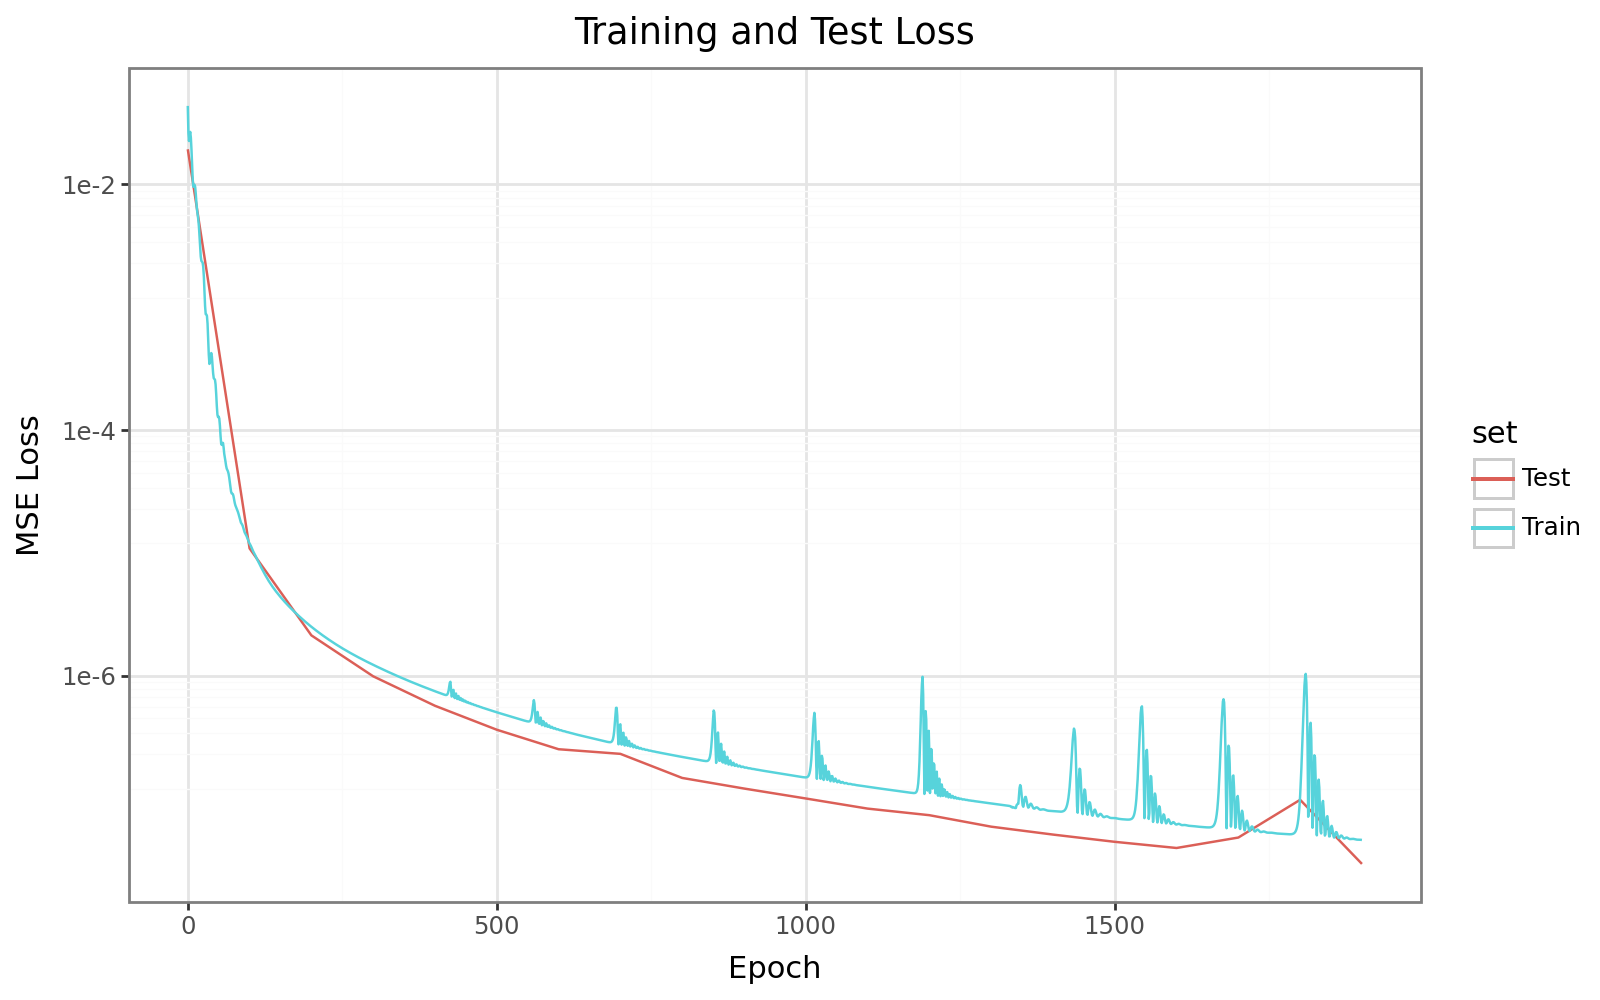

In [5]:
def split_data(Y_in, Y_tgt, train_fraction=0.8):
    n_samples = Y_in.shape[0]
    n_train = int(n_samples * train_fraction)
    Y_in_train = Y_in[:n_train]
    Y_tgt_train = Y_tgt[:n_train]
    Y_in_test  = Y_in[n_train:]
    Y_tgt_test = Y_tgt[n_train:]
    return Y_in_train, Y_tgt_train, Y_in_test, Y_tgt_test

def train_phospho_mapping(mapping_module, Y_input_train, Y_target_train, Y_input_test, Y_target_test, num_epochs=1000, lr=1e-3, print_freq=100):
    """
    Train the mapping module to predict Y_target (Y_fullFull) from Y_input (Y_fullprotein).
    
    Parameters:
       mapping_module: instance of the mapping module.
       Y_input_train: Tensor of training input (e.g., Y_fullprotein) with shape (samples_train, time_points, n_nodes)
       Y_target_train: Tensor of training target (e.g., Y_fullFull) with shape (samples_train, time_points, n_sites)
       Y_input_test: Tensor of test input with shape (samples_test, time_points, n_nodes)
       Y_target_test: Tensor of test target with shape (samples_test, time_points, n_sites)
       num_epochs: number of epochs to train.
       lr: learning rate.
       print_freq: frequency (in epochs) at which to print and update the loss plot.
       
    Returns:
       mapping_module: the trained model
       final_loss: the final loss value
    """
    device = mapping_module.device
    Y_input_train = Y_input_train.to(device)
    Y_target_train = Y_target_train.to(device)
    Y_input_test = Y_input_test.to(device)
    Y_target_test = Y_target_test.to(device)
    
    optimizer = torch.optim.Adam(mapping_module.parameters(), lr=lr)
    loss_history_list = []
    
    mask = ~torch.isnan(Y_target_train)
    mask_test = ~torch.isnan(Y_target_test)
    
    for epoch in range(num_epochs):
        mapping_module.train()
        optimizer.zero_grad()
            
        # Forward pass: compute predictions from the input Y_fullprotein
        Y_pred = mapping_module(Y_input_train)
        
        train_loss = torch.nn.functional.mse_loss(
            Y_pred.masked_fill(~mask, 0.0),
            Y_target_train.masked_fill(~mask, 0.0)
        )
        train_loss.backward()
        optimizer.step()
        
        # Record training loss
        loss_history_list.append({"epoch": epoch, "loss": train_loss.item(), "set": "Train"})
        
        if epoch % print_freq == 0:
            mapping_module.eval()
            with torch.no_grad():
                Y_test_pred = mapping_module(Y_input_test)
                test_loss = torch.nn.functional.mse_loss(
                    Y_test_pred.masked_fill(~mask_test, 0.0),
                    Y_target_test.masked_fill(~mask_test, 0.0)
                )
            loss_history_list.append({"epoch": epoch, "loss": test_loss.item(), "set": "Test"})
            
            loss_df = pd.DataFrame(loss_history_list)
            p_loss = (p9.ggplot(loss_df, p9.aes(x="epoch", y="loss", color="set"))
                      + p9.geom_line()
                      + p9.labs(x="Epoch", y="MSE Loss", title="Training and Test Loss")
                      + p9.scale_y_log10()
                      + p9.theme_bw()
                      + p9.theme(figure_size=(8, 5)))
            clear_output(wait=True)
            display(p_loss)
    
    return mapping_module, train_loss

# Import data and convert them to tensors
y_data = pd.read_csv(os.path.join('data', 'synthetic_data_y_scaled.csv'), sep=',', low_memory=False, index_col=0)
y_protein = pd.read_csv(os.path.join('data', 'synthetic_data_y_protein.csv'), sep=',', low_memory=False, index_col=0)
nodes_sites_map = pd.read_csv(os.path.join('data', 'nodes_sites_map.csv'), sep=',', low_memory=False, index_col=0)
net = pd.read_csv('data/KEGGnet-Model.tsv', sep = '\t', index_col = False)

Y_in = torch.tensor(y_protein.values, dtype=torch.float32)
Y_actual = torch.tensor(y_data.values, dtype=torch.float32)

Y_actual_reshaped = Y_actual.view(8, 48, -1)
Y_actual_reshaped = Y_actual_reshaped.permute(1, 0, 2).contiguous()
Y_in_reshaped = Y_in.view(8, 48, -1)
Y_in_reshaped = Y_in_reshaped.permute(1, 0, 2).contiguous()

Y_in_train, Y_tgt_train, Y_in_test, Y_tgt_test = split_data(Y_in_reshaped, Y_actual_reshaped, train_fraction=0.8)

# Naive approach
# mapping_module = NodesSitesMapping(nodes_sites_map, hidden_layers=None, device='cpu')

# Embedding approach
mapping_module = NodesSitesMapping_embedding(nodes_sites_map, conn_dim=10, hidden_layers={1: 64}, device='cpu')

trained_module, final_train_loss = train_phospho_mapping(mapping_module, Y_in_train, Y_tgt_train, Y_in_test, Y_tgt_test, num_epochs=2000, lr=1e-2, print_freq=100)

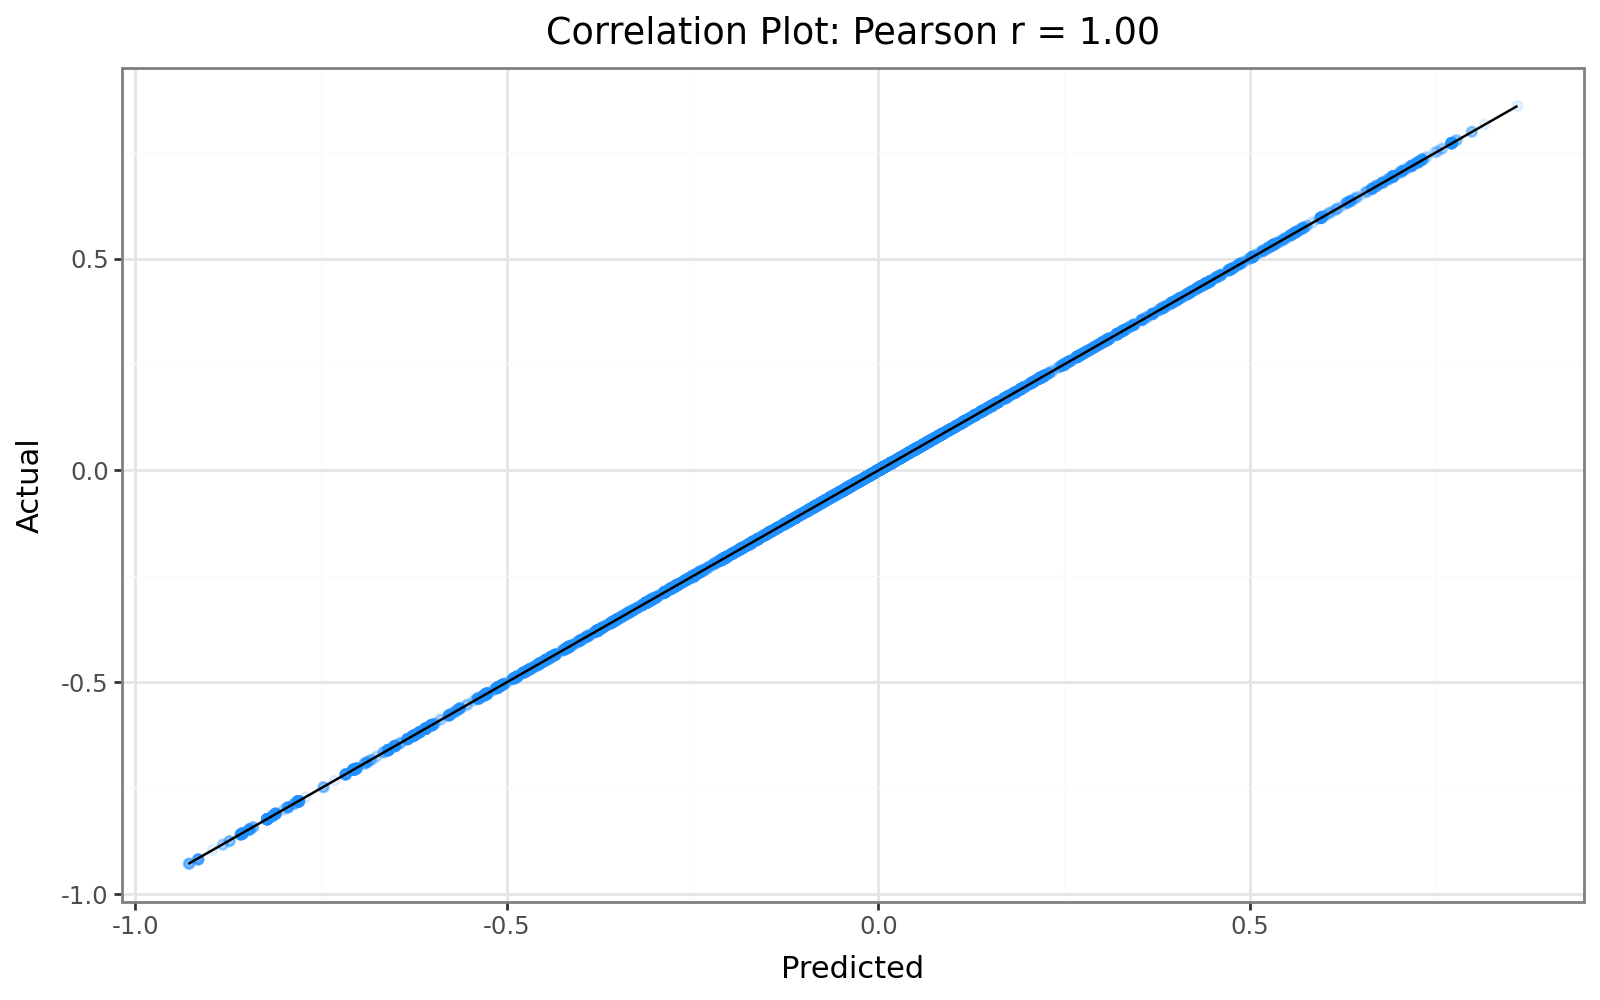

In [6]:
device = mapping_module.device
Y_input = Y_in_test.to(device)

Y_pred = mapping_module(Y_input)
Y_pred = Y_pred - Y_pred[0:1, :, :]  # Normalize to the first time point
Y_tgt_test = Y_tgt_test - Y_tgt_test[0:1, :, :]

mask_eval = ~torch.isnan(Y_tgt_test)

Y_pred_masked = Y_pred.masked_fill(~mask_eval, 0.0)
Y_tgt_test_masked = Y_tgt_test.masked_fill(~mask_eval, 0.0)

pred_np = Y_pred_masked.detach().cpu().numpy().flatten()
actual_np = Y_tgt_test_masked.detach().cpu().numpy().flatten()

df_corr = pd.DataFrame({"Predicted": pred_np, "Actual": actual_np})

pr, _ = pearsonr(df_corr["Predicted"], df_corr["Actual"])
min_val = min(df_corr["Predicted"].min(), df_corr["Actual"].min())
max_val = max(df_corr["Predicted"].max(), df_corr["Actual"].max())

line_df = pd.DataFrame({"x": [min_val, max_val], "y": [min_val, max_val]})

p_corr = (p9.ggplot(df_corr, p9.aes(x="Predicted", y="Actual"))
          + p9.geom_point(color="#1E90FF", alpha=0.1)
          + p9.geom_line(data=line_df, mapping=p9.aes(x="x", y="y"), color="black")
          + p9.labs(x="Predicted", y="Actual", title=f"Correlation Plot: Pearson r = {pr:.2f}")
          + p9.theme_bw()
          + p9.theme(figure_size=(8,5)))
p_corr.show()

2. Generate data with standard input t from different functions (simulate different sites). Do this twice with different function parameters each time (simulate nodes). Train the model on these synthetic data with X ~ nodes and Y ~ phosphosites, predict, and benchmark the mapping for different configurations of the embedding approach.

Training with conn_dim=1, flat...
Training with conn_dim=5, flat...
Training with conn_dim=5, hidden=[40]...
Training with conn_dim=5, hidden=[64, 32]...
Training with conn_dim=20, hidden=[64, 32]...
Final loss values:
                         config  final_loss
4  conn_dim=20, hidden=[64, 32]    0.014419
2       conn_dim=5, hidden=[40]    0.014661
3   conn_dim=5, hidden=[64, 32]    0.017198
1              conn_dim=5, flat    0.611079
0              conn_dim=1, flat    0.612278

Overall correlations:
                         config  correlation
0              conn_dim=1, flat     0.933124
1              conn_dim=5, flat     0.933258
2       conn_dim=5, hidden=[40]     0.998459
3   conn_dim=5, hidden=[64, 32]     0.998219
4  conn_dim=20, hidden=[64, 32]     0.999645


c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\themes\themeable.py:2419: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


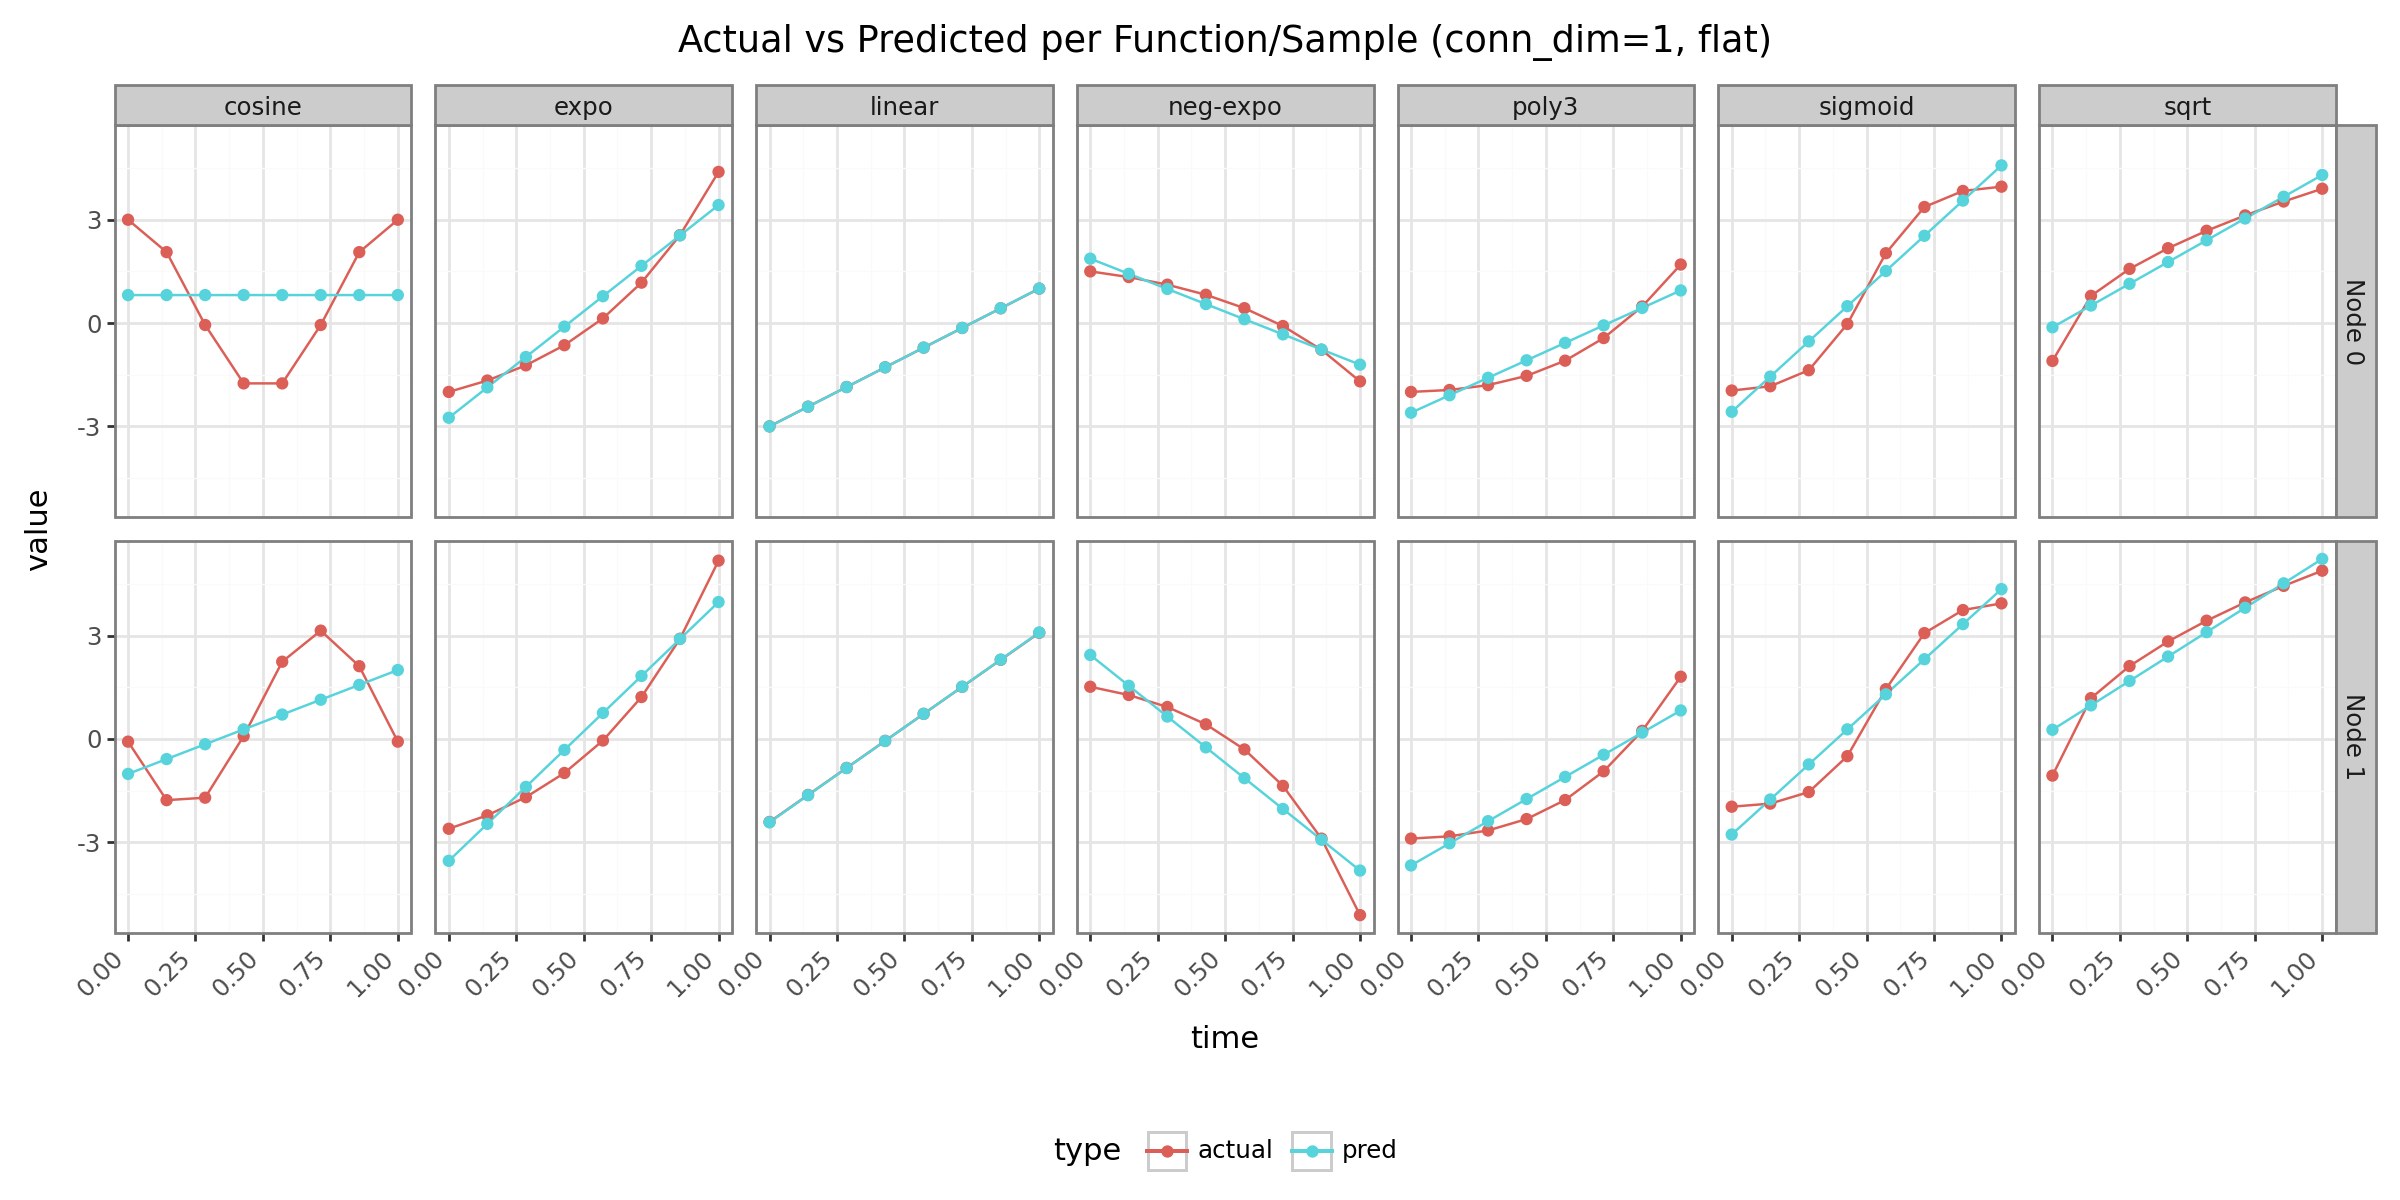

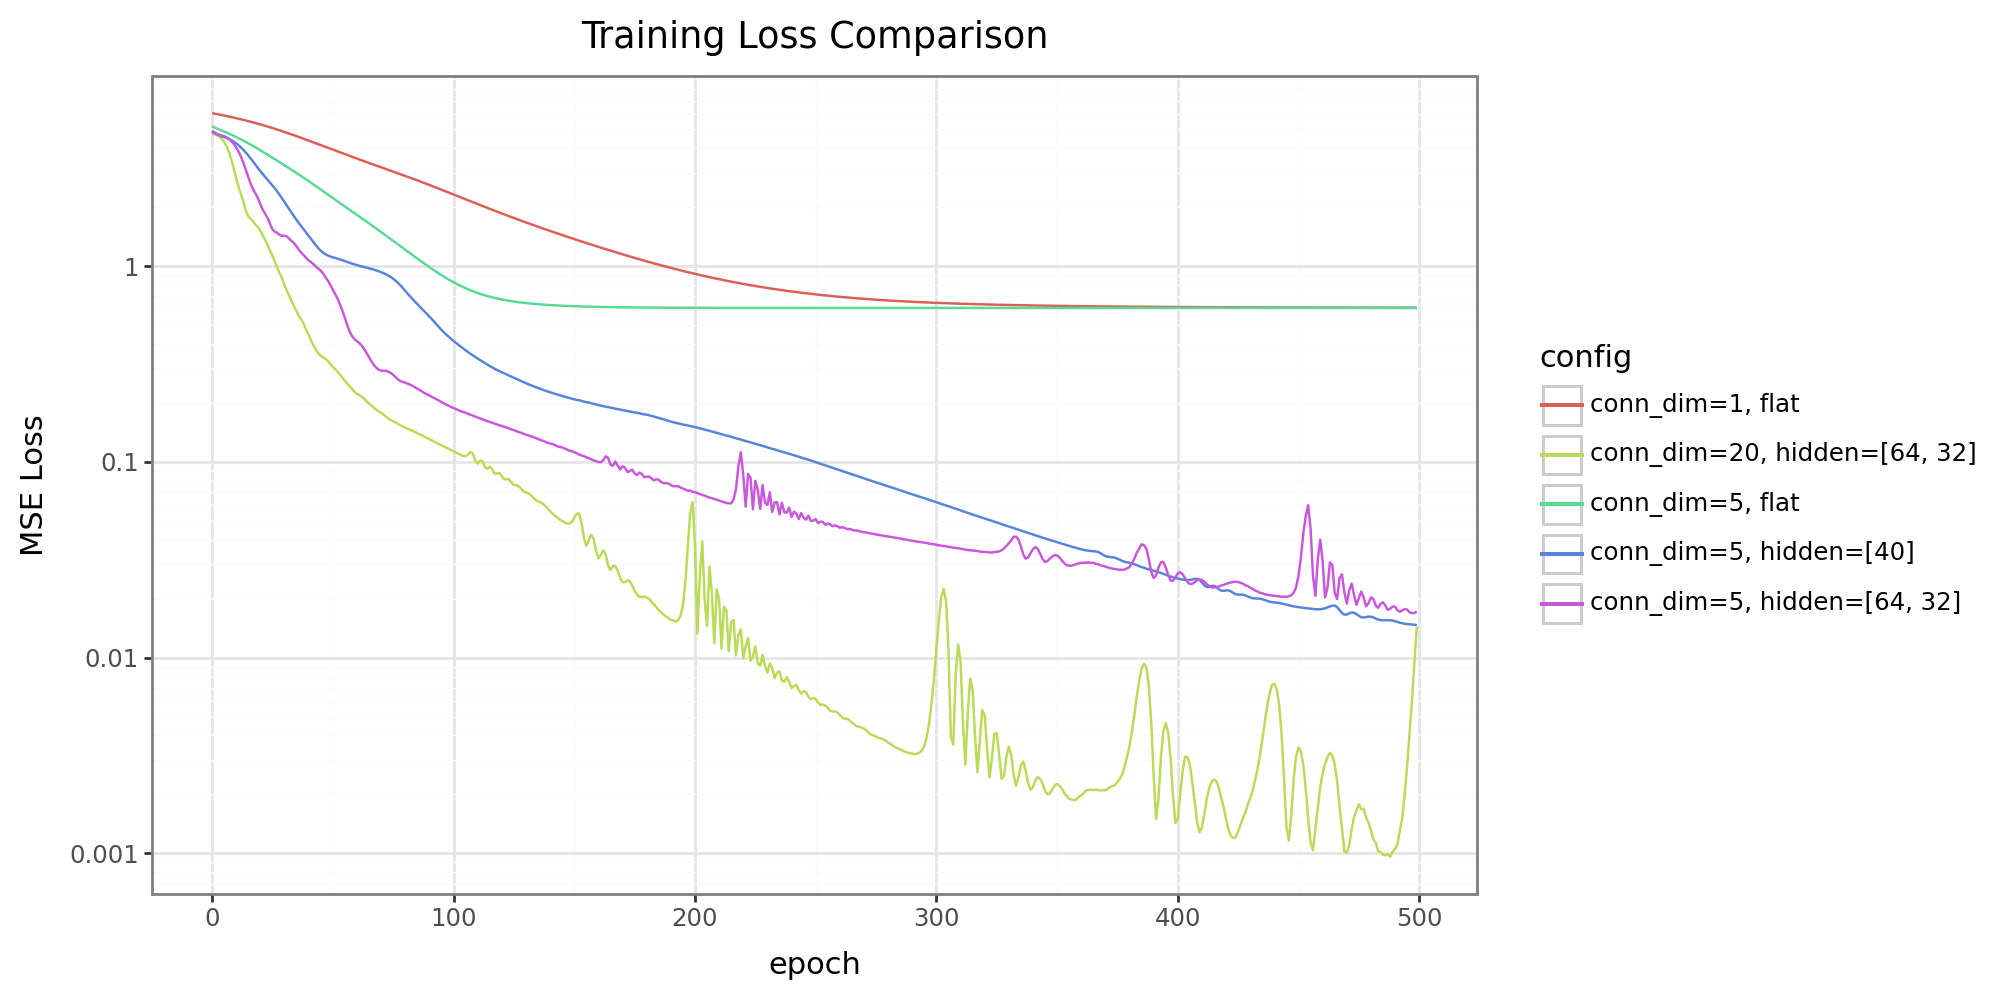

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\plotnine\themes\themeable.py:2419: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


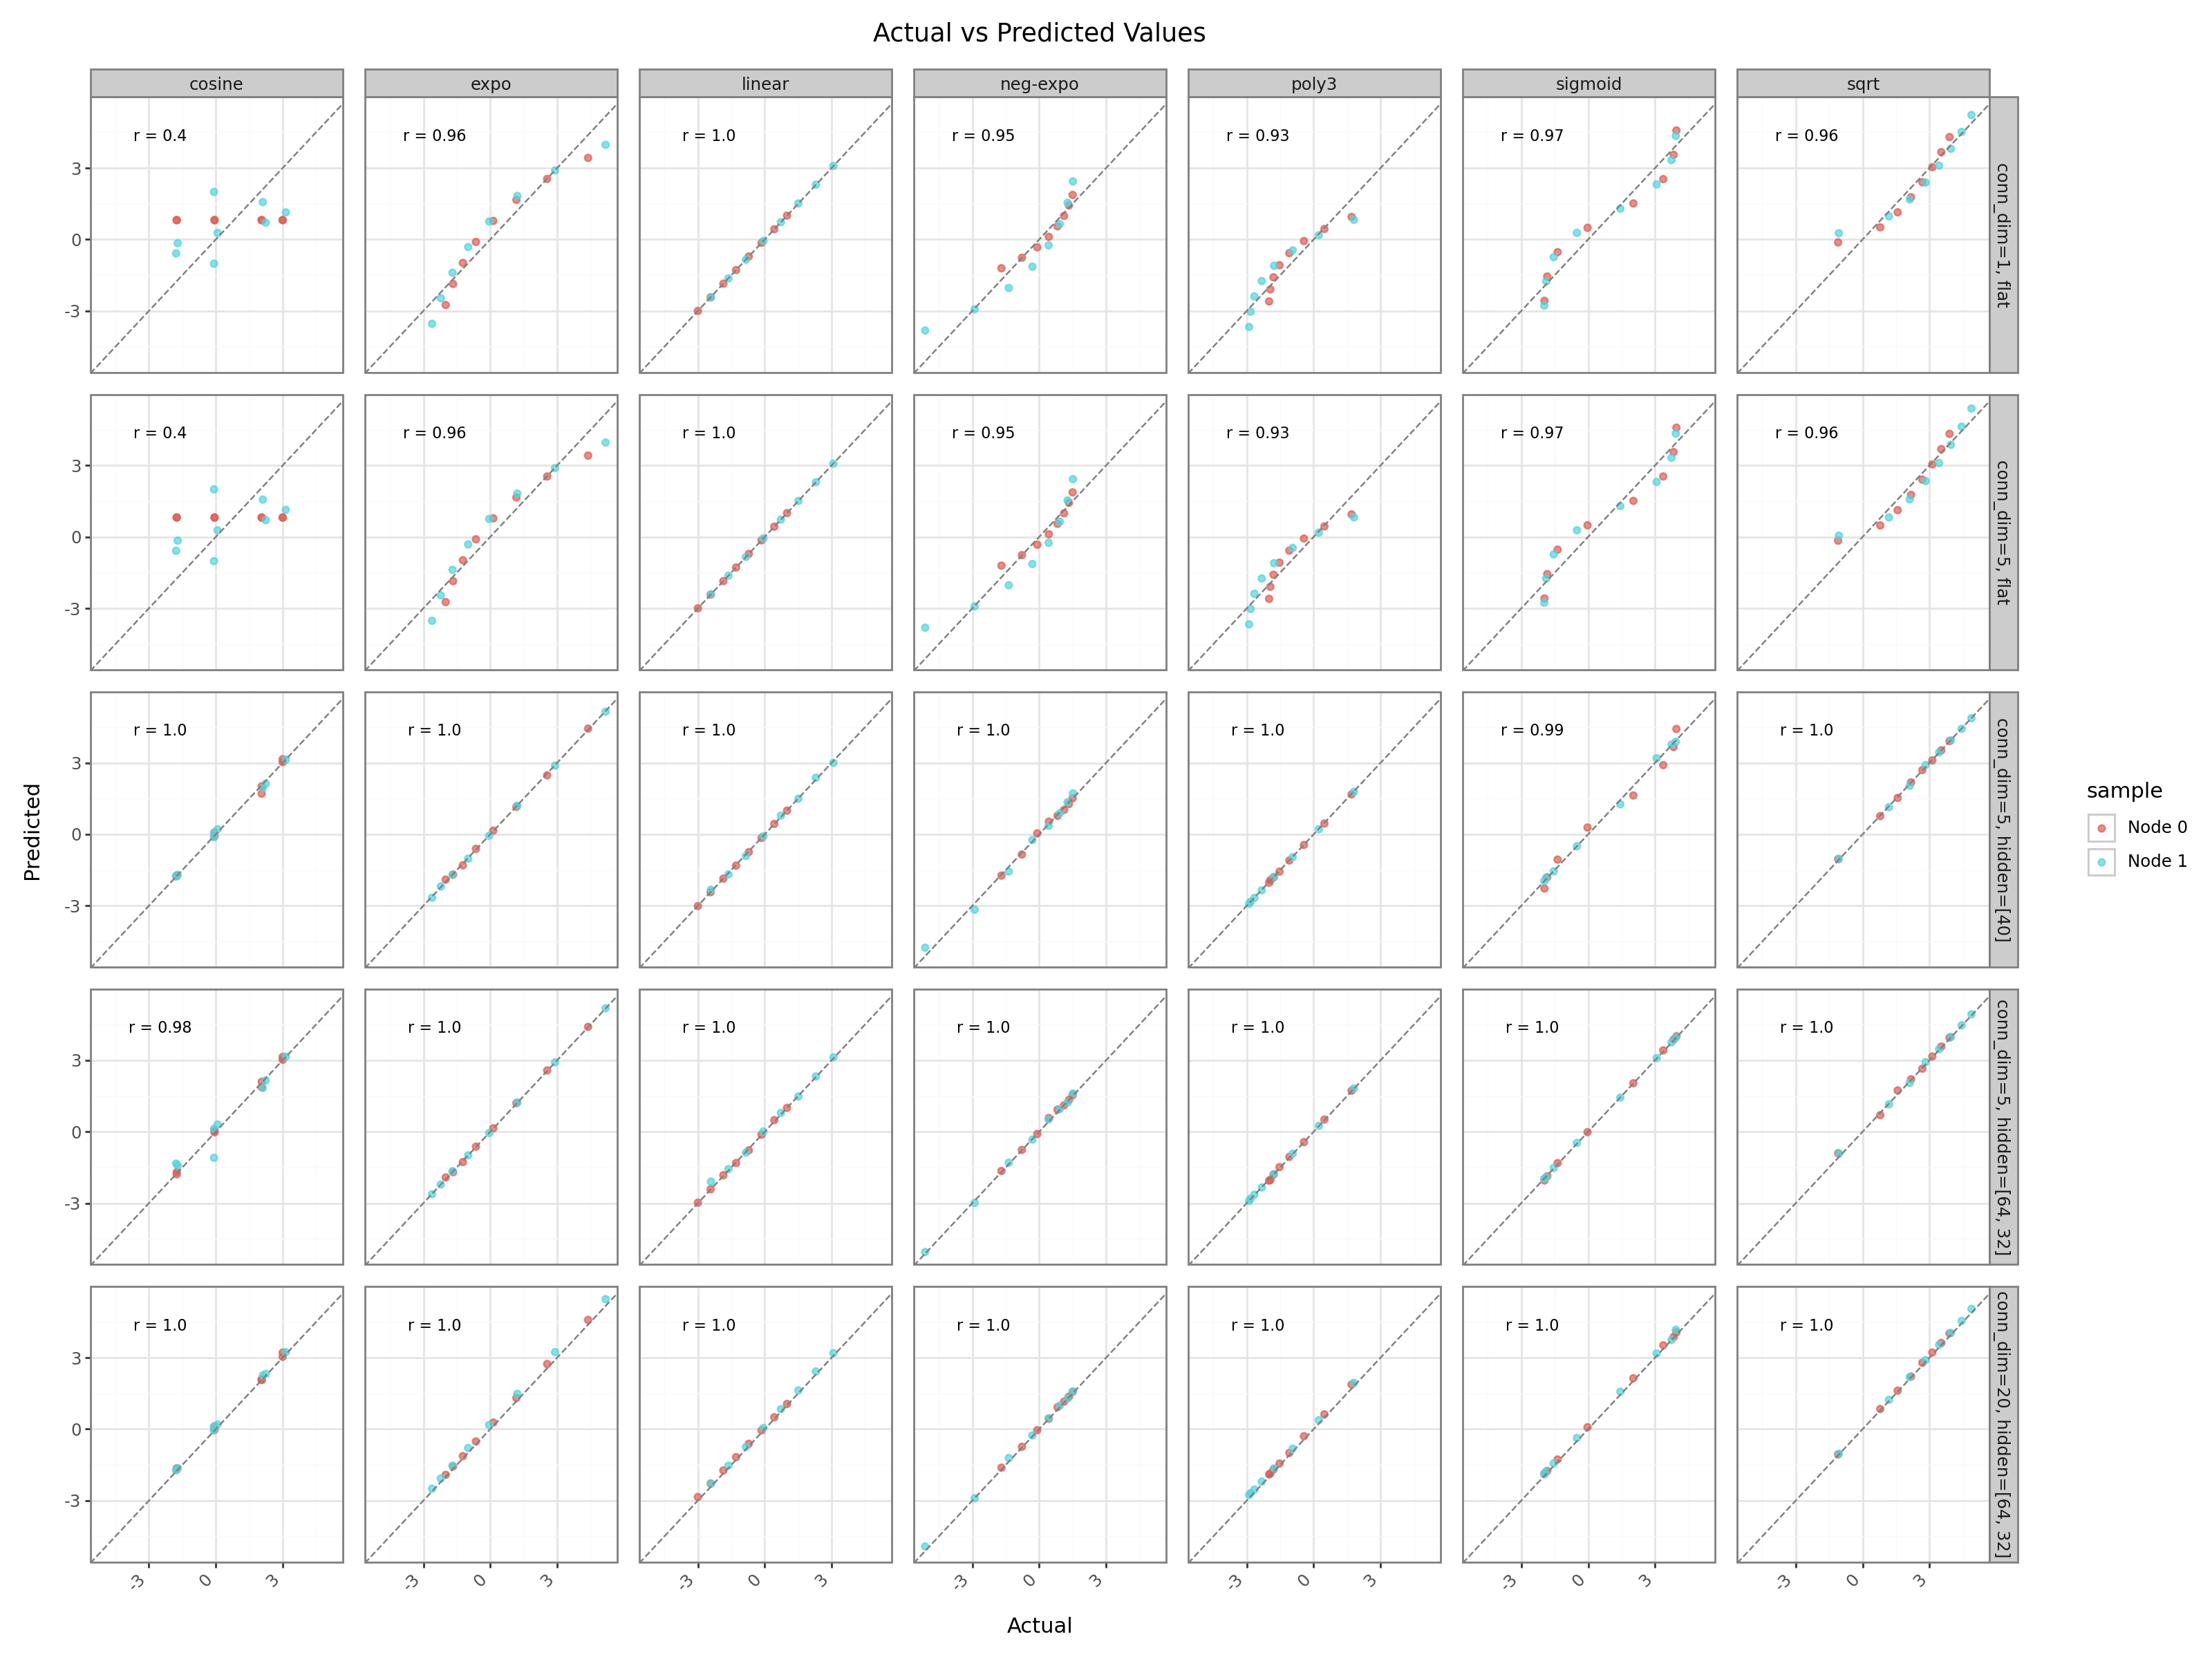

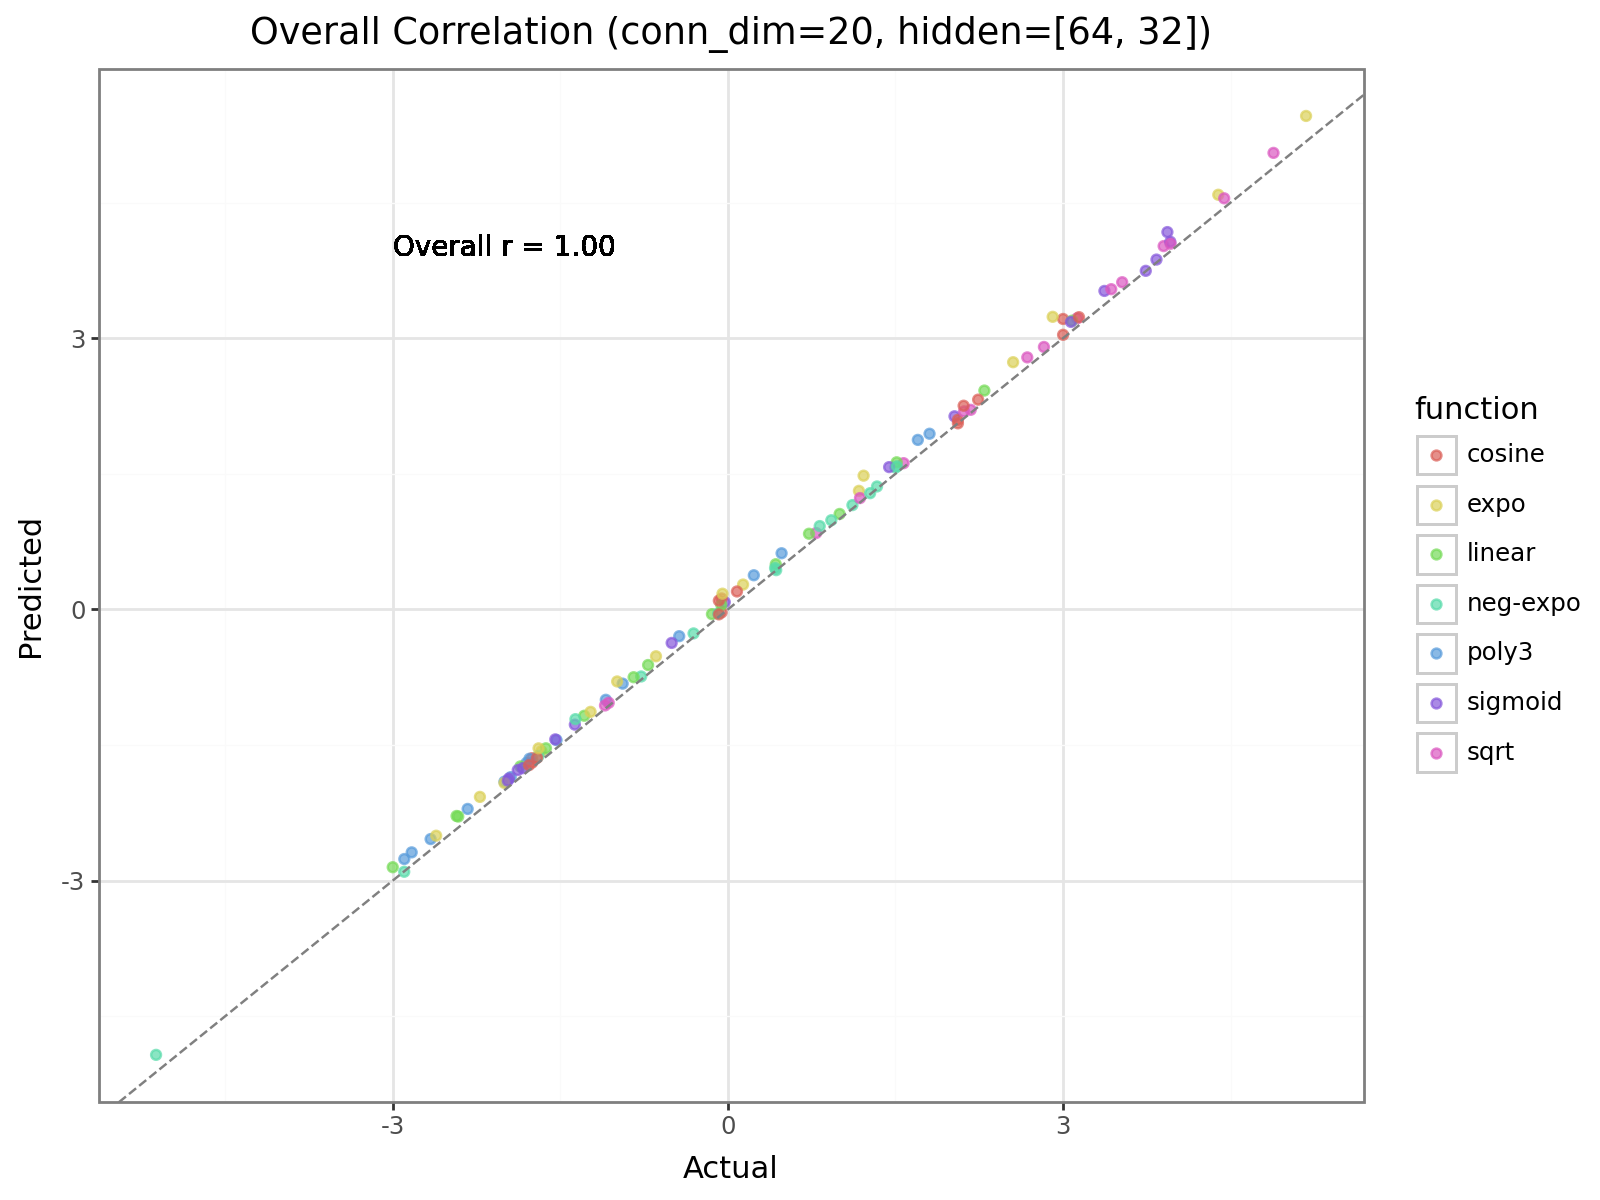

In [7]:
def run_unit_test():
    torch.manual_seed(0)
    np.random.seed(0)

    t = np.linspace(0, 1, 8)

    def poly3(t,a,b,c,d):  return a*t**3 + b*t**2 + c*t + d
    def linear(t,a,b):     return a*t + b
    def sqrtf(t,a,b):      return a*np.sqrt(t) + b
    def sigmoid(t,a,b):    return 6/(1+np.exp(-a*(t-b)))-2
    def cosine(t,amp,ph):  return amp*(np.cos(2*np.pi*(t+ph))+1)/2-2
    def expo(t,a,b,c):       return a*(np.exp(b*t)+c)

    func_list = [
        ("poly3",   poly3,  {"a":2.5,"b":1.0,"c":0.2,"d":-2.0}),
        ("linear",  linear, {"a":4,"b":-3}),
        ("sqrt",    sqrtf,  {"a":5.0,"b":-1.1}),
        ("sigmoid", sigmoid,{"a":10.0,"b":0.5}),
        ("cosine",  cosine, {"amp":5,"ph":1.0}),
        ("expo",    expo,   {"a":1,"b":2.0, "c":-3}),
        ("neg-expo",    expo,   {"a":-0.5,"b":2.0, "c":-4}),
        #("oscillator", oscillator,  {"A": 1.0, "zeta": 2.0, "omega0": 10.0, "phi": 0.0, "C": 0.0}),
    ]

    n_nodes = 2
    n_funcs = len(func_list)
    n_sites = n_nodes * n_funcs
    
    # Simulate Y_actual: shape (2,8,7)
    Y_actual_np = np.zeros((1, t.size, n_sites), float)
    for s, (name, func, base) in enumerate(func_list):
        # add 10% noise to base params for sample 1
        params0 = base
        params1 = {k: v*(1+0.2*np.random.randn()) for k,v in base.items()}
        Y_actual_np[0,:,2*s] = func(t, **params0)
        Y_actual_np[0,:,2*s+1] = func(t, **params1)
    Y_actual = torch.tensor(Y_actual_np, dtype=torch.float32)  # shape (2, 8, 14)
    
    # Build Y_full shape (2,8,2)
    Y_full = torch.tensor(t, dtype=torch.float32)
    Y_full = Y_full.view(1, -1, 1).expand(1, -1, n_nodes)  # shape (2, 8, 2)
    
    # Build nodes_sites_map: 14×2 DataFrame
    rows = [f"func_{f}_sample_{s}" for f in range(n_funcs) for s in range(n_nodes)]
    cols = [f"node_{i}" for i in range(n_nodes)]
    nodes_sites_map = pd.DataFrame(0.0, index=rows, columns=cols)
    for f in range(n_funcs):
        for s in range(n_nodes):
            row = f"func_{f}_sample_{s}"
            nodes_sites_map.loc[row, f"node_{s}"] = 1.0
    
    # Train the embedding module
    configs = [
        {"name": "conn_dim=1, flat", "conn_dim": 1, "hidden_layers": None},
        {"name": "conn_dim=5, flat", "conn_dim": 5, "hidden_layers": None},
        {"name": "conn_dim=5, hidden=[40]", "conn_dim": 5, "hidden_layers": {1: 64}},
        {"name": "conn_dim=5, hidden=[64, 32]", "conn_dim": 5, "hidden_layers": {1: 64, 2: 32}},
        {"name": "conn_dim=20, hidden=[64, 32]", "conn_dim": 20, "hidden_layers": {1: 64, 2: 32}}
    ]
    
    results = {}
    all_traj_records = []
    all_scatter_records = []
    overall_corr_records = []
    
    for config in configs:
        print(f"Training with {config['name']}...")
        model = NodesSitesMapping_embedding(nodes_sites_map, 
                                           conn_dim=config['conn_dim'], 
                                           hidden_layers=config['hidden_layers'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
        n_epochs = 500
        loss_hist = []
        
        for epoch in range(n_epochs):
            optimizer.zero_grad()
            Y_pred = model(Y_full)          # -> (2,8,14)
            loss = F.mse_loss(Y_pred, Y_actual)
            loss.backward()
            optimizer.step()
            loss_hist.append(float(loss))
        
        results[config['name']] = {
            'model': model,
            'loss_hist': loss_hist,
            'final_loss': loss_hist[-1],
            'Y_pred': Y_pred.detach().cpu().numpy()
        }
        
        # Collect trajectory records for this configuration
        Y_pred_np = results[config['name']]['Y_pred']
        
        for s in range(2):
            for f in range(n_funcs):
                idx = f * 2 + s
                func_name = func_list[f][0]
                for i, tt in enumerate(t):
                    # Actual values - only add once across all configs
                    if config == configs[0]:
                        all_traj_records.append({
                            "sample": f"Node {s}",
                            "function": func_name,
                            "time": tt,
                            "value": Y_actual_np[0, i, idx],
                            "type": "actual",
                            "config": config['name']
                        })
                    # Predicted values - add for each config
                    all_traj_records.append({
                        "sample": f"Node {s}",
                        "function": func_name,
                        "time": tt,
                        "value": Y_pred_np[0, i, idx],
                        "type": "pred",
                        "config": config['name']
                    })
                    
                # Add scatter data for each configuration
                actual = Y_actual_np[0, :, idx]
                pred = Y_pred_np[0, :, idx]
                for i in range(len(t)):
                    all_scatter_records.append({
                        "sample": f"Node {s}",
                        "function": func_name,
                        "actual": actual[i],
                        "predicted": pred[i],
                        "config": config['name']
                    })
        
        # Calculate overall correlation for this configuration
        all_actual = Y_actual_np[0, :, :].flatten()
        all_pred = Y_pred_np[0, :, :].flatten()
        overall_pr, _ = pearsonr(all_pred, all_actual)
        overall_corr_records.append({
            "config": config['name'],
            "correlation": overall_pr
        })
    
    # Create combined trajectory dataframe
    traj_df = pd.DataFrame(all_traj_records)
    
    # Create loss history dataframe
    loss_records = []
    for config_name, data in results.items():
        for epoch, loss in enumerate(data['loss_hist']):
            loss_records.append({
                'epoch': epoch,
                'loss': loss,
                'config': config_name
            })
    loss_df = pd.DataFrame(loss_records)
    
    # Create scatter dataframe
    scatter_df = pd.DataFrame(all_scatter_records)
    
    # Calculate correlations for each configuration and function
    corr_records = []
    for config_name, data in results.items():
        Y_pred_np = data['Y_pred']
        for f in range(n_funcs):
            func_name = func_list[f][0]
            
            # Get all nodes data for each function
            actual_all = Y_actual_np[0, :, [f*2, f*2+1]].flatten()
            pred_all = Y_pred_np[0, :, [f*2, f*2+1]].flatten()
            
            # Calculate Pearson correlation
            pr, _ = pearsonr(pred_all, actual_all)
            
            # Store correlation data
            corr_records.append({
                "function": func_name,
                "correlation": pr,
                "config": config_name
            })
    
    corr_df = pd.DataFrame(corr_records)
    overall_corr_df = pd.DataFrame(overall_corr_records)
    
    # Plot trajectories - only for the last configuration
    first_config = configs[0]['name']
    first_config_traj = traj_df[traj_df['config'] == first_config]
    
    p1 = (
      p9.ggplot(first_config_traj, p9.aes("time","value", color="type"))
      + p9.geom_line()
      + p9.geom_point()
      + p9.facet_grid("sample~function")
      + p9.labs(title=f"Actual vs Predicted per Function/Sample ({first_config})")
      + p9.theme_bw()
      + p9.theme(figure_size=(12, 6),
                subplots_adjust={'wspace':0.2, 'hspace':0.4},
                axis_text_x=p9.element_text(rotation=45, hjust=1),
                legend_position='bottom'))
    
    # Plot loss curves for all configurations
    p2 = (
      p9.ggplot(loss_df, p9.aes("epoch", "loss", color="config"))
      + p9.geom_line()
      + p9.scale_y_log10()
      + p9.labs(title="Training Loss Comparison", y="MSE Loss")
      + p9.theme_bw()
      + p9.theme(figure_size=(10, 5))
    )
    
    # Add correlation text to the scatter data for annotation
    corr_text = corr_df.copy()
    corr_text['label'] = 'r = ' + corr_text['correlation'].round(2).astype(str)
    
    desired_order = ["conn_dim=1, flat", "conn_dim=5, flat", "conn_dim=5, hidden=[40]", 
                "conn_dim=5, hidden=[64, 32]", "conn_dim=20, hidden=[64, 32]"]

    scatter_df['config'] = pd.Categorical(scatter_df['config'], 
                                        categories=desired_order, 
                                        ordered=True)

    corr_df['config'] = pd.Categorical(corr_df['config'], 
                                    categories=desired_order, 
                                    ordered=True)

    corr_text['config'] = pd.Categorical(corr_text['config'],
                                        categories=desired_order,
                                        ordered=True)

    p3 = (
        p9.ggplot(scatter_df, p9.aes('actual', 'predicted'))
        + p9.geom_point(p9.aes(color='sample'), alpha=0.7)
        + p9.geom_abline(intercept=0, slope=1, linetype='dashed', color='gray')
        + p9.geom_text(
            p9.aes(x=-2.5, y=4, label='label'),
            data=corr_text,
            inherit_aes=False,
            color='black',
            size=8,
            ha='center',
            va='bottom'
        )
        + p9.facet_grid('config~function', scales='fixed')
        + p9.labs(title='Actual vs Predicted Values', x='Actual', y='Predicted')
        + p9.theme_bw()
        + p9.theme(figure_size=(16, 12), 
                   subplots_adjust={'wspace':0.3, 'hspace':0.3},
                   axis_text_x=p9.element_text(rotation=45, hjust=1))
    )
    
    # Plot overall correlation for the last configuration
    last_config = configs[-1]['name']
    last_config_scatter = scatter_df[scatter_df['config'] == last_config]
    last_config_corr = overall_corr_df[overall_corr_df['config'] == last_config]['correlation'].values[0]
    
    p4 = (
        p9.ggplot(last_config_scatter, p9.aes('actual', 'predicted'))
        + p9.geom_point(p9.aes(color='function'), alpha=0.7)
        + p9.geom_abline(intercept=0, slope=1, linetype='dashed', color='gray')
        + p9.geom_text(
            p9.aes(x=-3, y=4),
            label=f'Overall r = {last_config_corr:.2f}',
            inherit_aes=False,
            color='black',
            size=10,
            ha='left'
        )
        + p9.labs(title=f'Overall Correlation ({last_config})', x='Actual', y='Predicted')
        + p9.theme_bw()
        + p9.theme(figure_size=(8, 6))
    )
    
    # Compare final loss values
    final_loss_df = pd.DataFrame([
        {"config": config, "final_loss": results[config]['final_loss']} 
        for config in results.keys()
    ])
    final_loss_df = final_loss_df.sort_values('final_loss')
    
    print("Final loss values:")
    print(final_loss_df)
    
    print("\nOverall correlations:")
    print(overall_corr_df)
    
    p1.show()
    p2.show()
    p3.show()
    p4.show()

if __name__=="__main__":
    run_unit_test()


3. Infer Kinase activity data from an ODE model (Huang-Ferrell model of the MAPK cascade), at the same time points and with the same input as the real data, and use it as input to map the respective phosphosites from that real data. The Kinases that we are simulate are: Raf, MEK, and ERK.

,Raf_active,MEK_active,ERK_active
Time,,,
0,0.000000,0.000000,0.000000
2,0.887912,0.453052,0.056732
4,0.956221,0.875811,0.677644
8,0.959585,0.936678,0.948907
12,0.959592,0.937167,0.951824


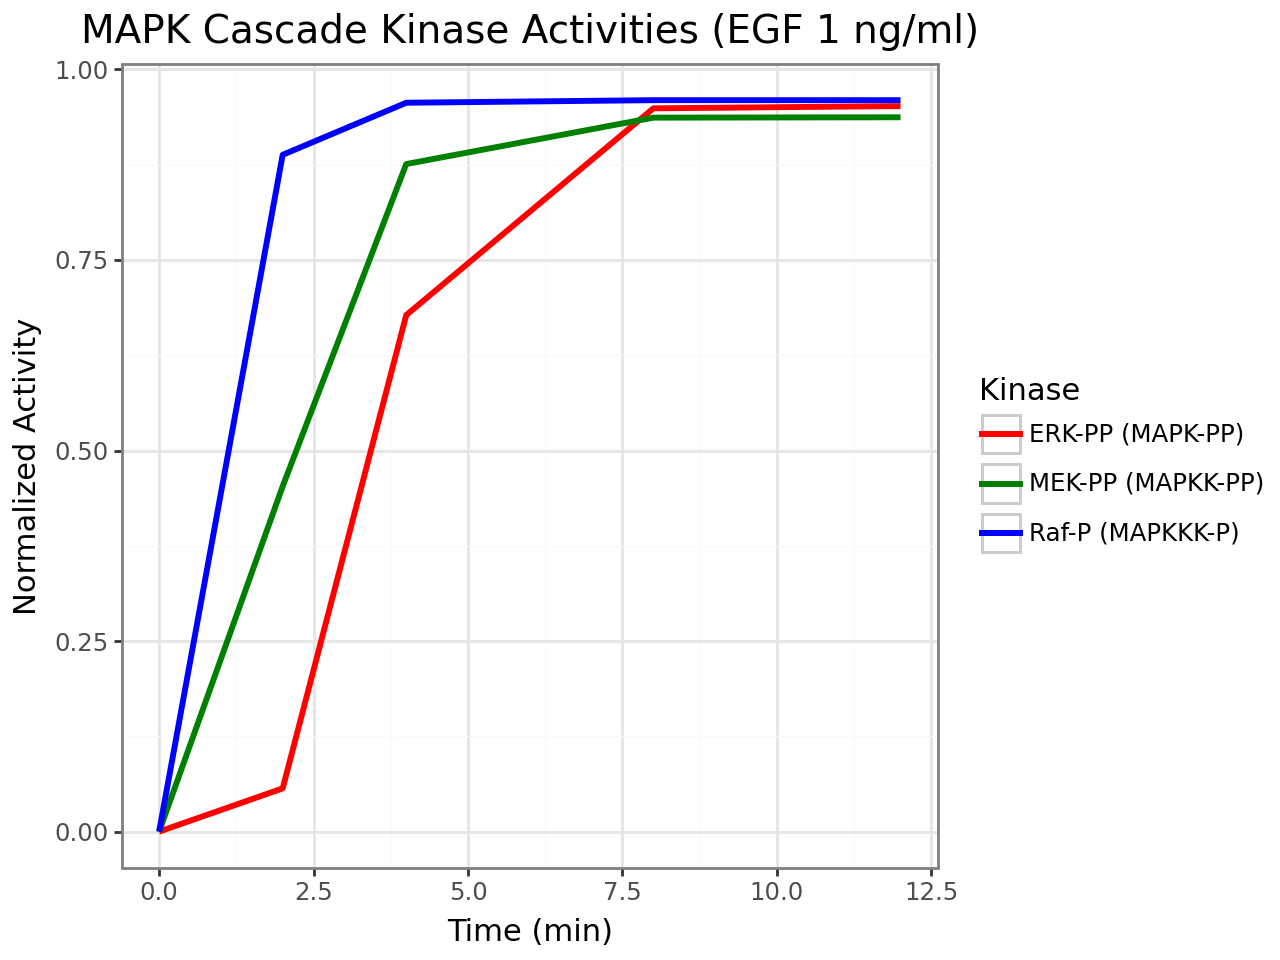

In [8]:
# Define the MAPK cascade model (Huang-Ferrell)
def mapk_cascade(t, y, params):
    """
    Implements the Huang-Ferrell MAPK cascade model ODE system.
    
    Parameters:
    t: time
    y: state vector containing concentrations
    params: dictionary of parameters
    
    Returns:
    dydt: time derivatives of the state variables
    """
    # MAPKKK (Raf) module
    MAPKKK = y[0]  # Inactive MAPKKK (Raf)
    pMAPKKK = y[1]  # Phosphorylated/active MAPKKK (Raf-P)
    
    # MAPKK (MEK) module
    MAPKK = y[2]  # Inactive MAPKK (MEK)
    pMAPKK = y[3]  # Mono-phosphorylated MAPKK (MEK-P)
    ppMAPKK = y[4]  # Dual-phosphorylated/active MAPKK (MEK-PP)
    
    # MAPK (ERK) module
    MAPK = y[5]  # Inactive MAPK (ERK)
    pMAPK = y[6]  # Mono-phosphorylated MAPK (ERK-P)
    ppMAPK = y[7]  # Dual-phosphorylated/active MAPK (ERK-PP)
    
    # Input signal (active receptor or equivalent)
    E1 = params['E1_base'] + params['E1_activated'] * (1 - np.exp(-params['k_egf'] * t))  # EGF-dependent activation of the first enzyme
    
    # Enzyme activities
    E2 = pMAPKKK  # MAPKKK-P acts as E2
    E3 = ppMAPKK  # MAPKK-PP acts as E3
    
    # Kinetic parameters
    v1 = params['v1']  # Max rate of MAPKKK activation by E1
    K1 = params['K1']  # Michaelis constant for E1 and MAPKKK
    v2 = params['v2']  # Max rate of MAPKKK-P inactivation by phosphatase
    K2 = params['K2']  # Michaelis constant for phosphatase and MAPKKK-P
    
    v3 = params['v3']  # Max rate of MAPKK activation by MAPKKK-P
    K3 = params['K3']  # Michaelis constant for MAPKKK-P and MAPKK
    v4 = params['v4']  # Max rate of MAPKK-P inactivation by phosphatase
    K4 = params['K4']  # Michaelis constant for phosphatase and MAPKK-P
    v5 = params['v5']  # Max rate of MAPKK-P activation by MAPKKK-P
    K5 = params['K5']  # Michaelis constant for MAPKKK-P and MAPKK-P
    v6 = params['v6']  # Max rate of MAPKK-PP inactivation by phosphatase
    K6 = params['K6']  # Michaelis constant for phosphatase and MAPKK-PP
    
    v7 = params['v7']  # Max rate of MAPK activation by MAPKK-PP
    K7 = params['K7']  # Michaelis constant for MAPKK-PP and MAPK
    v8 = params['v8']  # Max rate of MAPK-P inactivation by phosphatase
    K8 = params['K8']  # Michaelis constant for phosphatase and MAPK-P
    v9 = params['v9']  # Max rate of MAPK-P activation by MAPKK-PP
    K9 = params['K9']  # Michaelis constant for MAPKK-PP and MAPK-P
    v10 = params['v10']  # Max rate of MAPK-PP inactivation by phosphatase
    K10 = params['K10']  # Michaelis constant for phosphatase and MAPK-PP
    
    # Differential equations
    # MAPKKK module
    dMAPKKK_dt = -v1 * E1 * MAPKKK / (K1 + MAPKKK) + v2 * pMAPKKK / (K2 + pMAPKKK)
    dpMAPKKK_dt = v1 * E1 * MAPKKK / (K1 + MAPKKK) - v2 * pMAPKKK / (K2 + pMAPKKK)
    
    # MAPKK module
    dMAPKK_dt = -v3 * E2 * MAPKK / (K3 + MAPKK) + v4 * pMAPKK / (K4 + pMAPKK)
    dpMAPKK_dt = v3 * E2 * MAPKK / (K3 + MAPKK) - v4 * pMAPKK / (K4 + pMAPKK) - v5 * E2 * pMAPKK / (K5 + pMAPKK) + v6 * ppMAPKK / (K6 + ppMAPKK)
    dppMAPKK_dt = v5 * E2 * pMAPKK / (K5 + pMAPKK) - v6 * ppMAPKK / (K6 + ppMAPKK)
    
    # MAPK module
    dMAPK_dt = -v7 * E3 * MAPK / (K7 + MAPK) + v8 * pMAPK / (K8 + pMAPK)
    dpMAPK_dt = v7 * E3 * MAPK / (K7 + MAPK) - v8 * pMAPK / (K8 + pMAPK) - v9 * E3 * pMAPK / (K9 + pMAPK) + v10 * ppMAPK / (K10 + ppMAPK)
    dppMAPK_dt = v9 * E3 * pMAPK / (K9 + pMAPK) - v10 * ppMAPK / (K10 + ppMAPK)
    
    return [dMAPKKK_dt, dpMAPKKK_dt, dMAPKK_dt, dpMAPKK_dt, dppMAPKK_dt, dMAPK_dt, dpMAPK_dt, dppMAPK_dt]

# Set parameters for the model (based on Huang & Ferrell, 1996)
def get_model_parameters(egf_concentration=1.0):
    """
    Get parameters for the MAPK cascade model.
    
    Parameters:
    egf_concentration: concentration of EGF in ng/ml
    
    Returns:
    params: dictionary of parameters
    """
    params = {
        # EGF signal parameters - significantly stronger input signal
        'E1_base': 0.0,  # Basal E1 activity
        'E1_activated': 1.5 * egf_concentration,  # 5x stronger EGF effect
        'k_egf': 5.0,  # 5x faster EGF-induced activation
        
        # MAPKKK module (Raf) - faster activation and slower deactivation
        'v1': 5.0,  # 4x faster activation rate (was 2.5)
        'K1': 5.0,   # Lower Km for better binding (was 10.0)
        'v2': 1.0,   # 4x proportional increase in deactivation (was 0.25)
        'K2': 15.0,  # Higher Km for slower deactivation (was 8.0)
        
        # MAPKK module (MEK) - much faster activation
        'v3': 8.0,   # ~10x faster activation (was 0.75/0.9)
        'K3': 5.0,   # Lower Km for better binding (was 15.0/10.0)
        'v4': 2.0,   # Slower relative deactivation (was 0.75/0.6)
        'K4': 20.0,  # Higher Km for slower deactivation (was 15.0)
        'v5': 8.0,   # ~10x faster activation (was 0.75/0.9)
        'K5': 5.0,   # Lower Km for better binding (was 15.0/10.0)
        'v6': 2.0,   # Slower relative deactivation (was 0.75/0.6)
        'K6': 20.0,  # Higher Km for slower deactivation (was 15.0)
        
        # MAPK module (ERK) - dramatically faster activation
        'v7': 8.0,   # ~16x faster activation (was 0.5/0.7)
        'K7': 5.0,   # Lower Km for better binding (was 15.0/10.0)
        'v8': 1.5,   # Slower relative deactivation (was 0.5/0.3)
        'K8': 20.0,  # Higher Km for slower deactivation (was 15.0)
        'v9': 8.0,   # ~16x faster activation (was 0.5/0.7)
        'K9': 5.0,   # Lower Km for better binding (was 15.0/10.0)
        'v10': 1.5,  # Slower relative deactivation (was 0.5/0.3)
        'K10': 20.0  # Higher Km for slower deactivation (was 15.0)
    }
    
    return params

# Set initial conditions
def get_initial_conditions():
    """
    Get initial conditions for the MAPK cascade model.
    
    Returns:
    y0: list of initial conditions for each state variable
    """
    # Initial concentrations (normalized)
    MAPKKK_0 = 1.0  # Initial inactive MAPKKK
    pMAPKKK_0 = 0.0  # Initial active MAPKKK
    
    MAPKK_0 = 1.0  # Initial inactive MAPKK
    pMAPKK_0 = 0.0  # Initial mono-phosphorylated MAPKK
    ppMAPKK_0 = 0.0  # Initial active MAPKK
    
    MAPK_0 = 1.0  # Initial inactive MAPK
    pMAPK_0 = 0.0  # Initial mono-phosphorylated MAPK
    ppMAPK_0 = 0.0  # Initial active MAPK
    
    y0 = [MAPKKK_0, pMAPKKK_0, MAPKK_0, pMAPKK_0, ppMAPKK_0, MAPK_0, pMAPK_0, ppMAPK_0]
    return y0

# Simulate the model for EGF 1 ng/ml
def simulate_mapk_cascade(egf_concentration=1.0, t_max=15, t_points=None):
    """
    Simulate the MAPK cascade model with given EGF concentration.
    
    Parameters:
    egf_concentration: concentration of EGF in ng/ml
    t_max: maximum simulation time in minutes
    t_points: specific time points to output (if None, uses dense output)
    
    Returns:
    t: array of time points
    y: array of state variables at each time point
    """
    # Get parameters and initial conditions
    params = get_model_parameters(egf_concentration)
    y0 = get_initial_conditions()
    
    # Define specific time points for output
    if t_points is None:
        t_eval = np.linspace(0, t_max, 100)  # Dense output
    else:
        t_eval = t_points
    
    # Solve ODE system
    sol = solve_ivp(
        lambda t, y: mapk_cascade(t, y, params),
        [0, t_max],
        y0,
        method='LSODA',
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-9
    )
    
    return sol.t, sol.y

# Run the simulation with EGF 1 ng/ml at specific time points to match experimental data
time_points = np.array([0, 2, 4, 8, 12])
t, y = simulate_mapk_cascade(egf_concentration=1.0, t_max=15, t_points=time_points)

kinase_activities = pd.DataFrame({
    'Time': t,
    'Raf_active': y[1, :],  # pMAPKKK (Raf-P)
    'MEK_active': y[4, :],  # ppMAPKK (MEK-PP)
    'ERK_active': y[7, :]   # ppMAPK (ERK-PP)
})

# Set Time as index
kinase_activities.set_index('Time', inplace=True)
display(kinase_activities)

plot_data = kinase_activities.reset_index().melt(
    id_vars='Time', 
    value_vars=['Raf_active', 'MEK_active', 'ERK_active'],
    var_name='Kinase', 
    value_name='Activity'
)

plot_data['Kinase'] = plot_data['Kinase'].replace({
    'Raf_active': 'Raf-P (MAPKKK-P)',
    'MEK_active': 'MEK-PP (MAPKK-PP)',
    'ERK_active': 'ERK-PP (MAPK-PP)'
})

(p9.ggplot(plot_data, p9.aes('Time', 'Activity', color='Kinase'))
 + p9.geom_line(size=1.2)
 + p9.scale_color_manual(values=['red', 'green', 'blue'])
 + p9.labs(title='MAPK Cascade Kinase Activities (EGF 1 ng/ml)',
        x='Time (min)', 
        y='Normalized Activity')
 + p9.theme_bw()
 + p9.theme(plot_title=p9.element_text(size=14))
)

In [9]:
# Load the actual EGF phosphoproteomics data
y_data_actual = pd.read_csv(os.path.join('..', 'data', 'egf_y.csv'), sep=',', low_memory=False, index_col=0)
print(f"Original phosphoproteomics data shape: {y_data_actual.shape}")

# Define the UniProt IDs for our kinases of interest
kinase_uniprot_ids = {
    'Raf': ['P15056', 'P04049'],  # BRAF, RAF1
    'MEK': ['Q02750', 'P36507'],  # MAP2K1 (MEK1), MAP2K2 (MEK2)
    'ERK': ['P28482', 'P27361']   # MAPK1 (ERK2), MAPK3 (ERK1)
}

# Filter to keep only the kinase-related phosphosites
kinase_sites = []
for kinase, uniprot_ids in kinase_uniprot_ids.items():
    for uniprot_id in uniprot_ids:
        kinase_sites.extend([col for col in y_data_actual.columns if uniprot_id in col])

y_data_filtered = y_data_actual[kinase_sites]
print(f"Filtered phosphoproteomics data shape: {y_data_filtered.shape}")
print(f"Phosphosites retained: {len(kinase_sites)}")

display(y_data_filtered.head())

Original phosphoproteomics data shape: (10, 19065)
Filtered phosphoproteomics data shape: (10, 46)
Phosphosites retained: 46


,BRAF:P15056:S151s,BRAF:P15056:S335s,BRAF:P15056:S365s,BRAF:P15056:S432s,BRAF:P15056:S446s,BRAF:P15056:S447s,BRAF:P15056:S729s,BRAF:P15056:S750s,BRAF:P15056:T401t,BRAF:P15056:T440t,...,MP2K2:P36507:S26s,MP2K2:P36507:S306s,MP2K2:P36507:T17t,MP2K2:P36507:T25t,MP2K2:P36507:T394t,MK01:P28482:T185t,MK01:P28482:Y187y,MK03:P27361:T198t,MK03:P27361:T202t,MK03:P27361:Y204y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
EGF_R1_0,-0.563808,-1.020831,0.244279,-0.526568,-0.197324,-0.227810,-0.187092,-1.277437,-1.206809,0.056785,...,-1.400118,-0.797947,-1.537910,-0.826223,-0.805933,-2.620007,-2.620007,-1.295204,-1.316605,-1.295204
EGF_R2_0,-0.873643,-1.257305,0.310885,-0.095410,-0.265031,-0.188202,-0.154404,-1.682228,-1.314166,-0.703996,...,-1.487877,-1.085984,-1.581526,-0.919543,-0.531580,-2.711851,-2.711851,-1.308631,-1.141908,-1.308631
EGF_R1_2,-0.855824,-1.830161,0.006637,-0.183248,-0.261164,-0.346849,-0.185405,-1.744651,-1.312540,-0.241141,...,-1.659743,-0.799348,-1.693366,-0.699573,-0.506114,-2.979519,-2.979519,-1.246552,-0.897751,-1.246552
EGF_R2_2,-0.444818,-0.955715,0.201041,-2.093694,-0.782049,-0.317695,-0.255718,-1.192347,-0.979956,-0.660879,...,-1.461373,-0.066313,-1.455202,-1.063127,-0.646858,-2.184414,-2.184414,-0.998164,-1.738092,-0.998164
EGF_R1_4,0.009807,-0.939513,-0.463027,0.222019,-0.438167,-0.165734,-0.117432,-0.295120,-1.133785,0.032554,...,-1.536263,-0.265401,-1.397418,-0.744215,-0.471411,-0.441826,-0.441826,-0.218864,-0.254370,-0.218864


In [ ]:
egf_data = y_data_filtered[y_data_filtered.index.str.startswith('EGF')]
egf_data_df = egf_data.reset_index()
egf_data_df[['Treatment', 'Replicate', 'Time']] = egf_data_df['Drug_CL_Time'].str.split('_', expand=True)
egf_data_df = egf_data_df[egf_data_df['Replicate'].isin(['R2'])]
egf_data_df['Time'] = egf_data_df['Time'].astype(int)
egf_data_df = egf_data_df.sort_values(['Time', 'Replicate'])
time_points = sorted(egf_data_df['Time'].unique())
print(f"Time points in data: {time_points}")

replicates = sorted(egf_data_df['Replicate'].unique())
print(f"Replicates in data: {replicates}")

egf_data_sorted = egf_data_df.set_index('Drug_CL_Time')
egf_data_sorted = egf_data_sorted.drop(['Treatment', 'Replicate', 'Time'], axis=1)

display(egf_data_sorted.head())

y_array = []
for replicate in replicates:
    replicate_data = egf_data_df[egf_data_df['Replicate'] == replicate].sort_values('Time')
    replicate_sites = replicate_data.drop(['Drug_CL_Time', 'Treatment', 'Replicate', 'Time'], axis=1).values
    y_array.append(replicate_sites)

# Convert to tensor with shape (n_replicates, n_time_points, n_phosphosites)
Y_actual = torch.tensor(np.array(y_array), dtype=torch.float32)
print(f"Y_actual tensor shape: {Y_actual.shape}")

Time points in data: [0, 2, 4, 8, 12]
Replicates in data: ['R2']


,BRAF:P15056:S151s,BRAF:P15056:S335s,BRAF:P15056:S365s,BRAF:P15056:S432s,BRAF:P15056:S446s,BRAF:P15056:S447s,BRAF:P15056:S729s,BRAF:P15056:S750s,BRAF:P15056:T401t,BRAF:P15056:T440t,...,MP2K2:P36507:S26s,MP2K2:P36507:S306s,MP2K2:P36507:T17t,MP2K2:P36507:T25t,MP2K2:P36507:T394t,MK01:P28482:T185t,MK01:P28482:Y187y,MK03:P27361:T198t,MK03:P27361:T202t,MK03:P27361:Y204y
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
EGF_R2_0,-0.873643,-1.257305,0.310885,-0.095410,-0.265031,-0.188202,-0.154404,-1.682228,-1.314166,-0.703996,...,-1.487877,-1.085984,-1.581526,-0.919543,-0.531580,-2.711851,-2.711851,-1.308631,-1.141908,-1.308631
EGF_R2_2,-0.444818,-0.955715,0.201041,-2.093694,-0.782049,-0.317695,-0.255718,-1.192347,-0.979956,-0.660879,...,-1.461373,-0.066313,-1.455202,-1.063127,-0.646858,-2.184414,-2.184414,-0.998164,-1.738092,-0.998164
EGF_R2_4,-0.057535,-0.608987,-0.023617,0.428337,-0.582543,-0.335162,-0.121596,-0.340723,-1.074225,0.014070,...,-1.496107,-0.196475,-1.574743,-0.736769,-0.397033,-0.606608,-0.606608,-0.280812,-0.662767,-0.280812
EGF_R2_8,0.215870,-0.694394,-0.214911,0.140861,-0.161936,-0.013626,-0.056315,-0.196533,-0.996461,0.178116,...,-1.320968,-0.255454,-1.507768,-0.751396,0.089197,0.069699,0.069699,0.443529,0.311283,0.443529
EGF_R2_12,0.086079,-0.709132,-0.328743,0.485672,0.066996,0.010205,-0.158599,-0.239494,-0.741859,-0.442186,...,-1.183487,-0.632953,-1.036346,-0.735826,0.255938,-0.208370,-0.208370,-0.039882,-0.075888,-0.039882


Y_actual tensor shape: torch.Size([1, 5, 46])


In [ ]:
# Extract kinase activities from our simulation
X_kinase_activities = kinase_activities.copy()

x_array = []
for replicate in replicates:
    # Use the same kinase activities for each replicate
    x_array.append(X_kinase_activities.values)

# Convert to tensor with shape (n_replicates, n_time_points, n_kinases)
X_kinases = torch.tensor(np.array(x_array), dtype=torch.float32)
print(f"X_kinases tensor shape: {X_kinases.shape}")

display(X_kinase_activities)

X_kinases tensor shape: torch.Size([1, 5, 3])


,Raf_active,MEK_active,ERK_active
Time,,,
0,0.000000,0.000000,0.000000
2,0.887912,0.453052,0.056732
4,0.956221,0.875811,0.677644
8,0.959585,0.936678,0.948907
12,0.959592,0.937167,0.951824


In [ ]:
phosphosite_names = list(egf_data_sorted.columns)
kinase_names = list(X_kinase_activities.columns)

mapping_mask = pd.DataFrame(0, index=phosphosite_names, columns=kinase_names)

# Assign each phosphosite to the appropriate kinase based on UniProt ID
for site in phosphosite_names:
    site_uniprot = site.split(':')[1]
    
    # Assign to Raf
    if site_uniprot in kinase_uniprot_ids['Raf']:
        mapping_mask.loc[site, 'Raf_active'] = 1
    # Assign to MEK
    elif site_uniprot in kinase_uniprot_ids['MEK']:
        mapping_mask.loc[site, 'MEK_active'] = 1
    # Assign to ERK
    elif site_uniprot in kinase_uniprot_ids['ERK']:
        mapping_mask.loc[site, 'ERK_active'] = 1

print(f"Mapping mask shape: {mapping_mask.shape}")
print("\nMapping statistics:")
for kinase in kinase_names:
    print(f"  {kinase}: {mapping_mask[kinase].sum()} sites")
    
display(mapping_mask.head())

Mapping mask shape: (46, 3)

Mapping statistics:
  Raf_active: 29 sites
  MEK_active: 12 sites
  ERK_active: 5 sites


,Raf_active,MEK_active,ERK_active
BRAF:P15056:S151s,1,0,0
BRAF:P15056:S335s,1,0,0
BRAF:P15056:S365s,1,0,0
BRAF:P15056:S432s,1,0,0
BRAF:P15056:S446s,1,0,0


Epoch [100/3000], Loss: 0.1225
Epoch [200/3000], Loss: 0.0666
Epoch [300/3000], Loss: 0.0438
Epoch [400/3000], Loss: 0.0306
Epoch [500/3000], Loss: 0.0270
Epoch [600/3000], Loss: 0.0260
Epoch [700/3000], Loss: 0.0255
Epoch [800/3000], Loss: 0.0252
Epoch [900/3000], Loss: 0.0248
Epoch [1000/3000], Loss: 0.0255
Epoch [1100/3000], Loss: 0.0240
Epoch [1200/3000], Loss: 0.0238
Epoch [1300/3000], Loss: 0.0238
Epoch [1400/3000], Loss: 0.0235
Epoch [1500/3000], Loss: 0.0232
Epoch [1600/3000], Loss: 0.0230
Epoch [1700/3000], Loss: 0.0227
Epoch [1800/3000], Loss: 0.0225
Epoch [1900/3000], Loss: 0.0223
Epoch [2000/3000], Loss: 0.0220
Epoch [2100/3000], Loss: 0.0220
Epoch [2200/3000], Loss: 0.0224
Epoch [2300/3000], Loss: 0.0220
Epoch [2400/3000], Loss: 0.0217
Epoch [2500/3000], Loss: 0.0210
Epoch [2600/3000], Loss: 0.0210
Epoch [2700/3000], Loss: 0.0210
Epoch [2800/3000], Loss: 0.0210
Epoch [2900/3000], Loss: 0.0218
Epoch [3000/3000], Loss: 0.0212


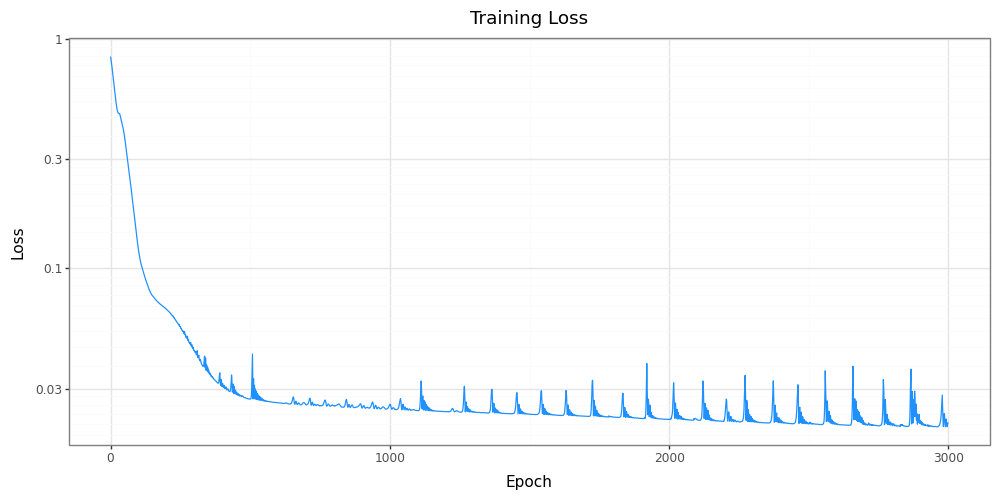

In [ ]:
# Initialize the phosphosite mapping module
conn_dim = 20
hidden_layers = {1: 64, 2: 64, 3: 64, 4: 32}

phosphosite_mapper = NodesSitesMapping_embedding(
    nodes_sites_map=mapping_mask,
    conn_dim=conn_dim,
    hidden_layers=hidden_layers,
    dtype=torch.float32,
    device='cpu'
)

# Set up training parameters
learning_rate = 1e-3
num_epochs = 3000
batch_size = X_kinases.shape[0]  # Use all replicates in each batch

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(phosphosite_mapper.parameters(), lr=learning_rate)

# Training loop
losses = []

for epoch in range(num_epochs):
    # Forward pass
    Y_pred = phosphosite_mapper(X_kinases)
    
    # Compute loss
    loss = criterion(Y_pred, Y_actual)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

loss_df = pd.DataFrame({"epoch": range(len(losses)), "loss": losses})
p_loss = (p9.ggplot(loss_df, p9.aes(x="epoch", y="loss"))
          + p9.geom_line(color="#1E90FF")
          + p9.scale_y_log10()
          + p9.labs(x="Epoch", y="Loss", title="Training Loss")
          + p9.theme_bw()
          + p9.theme(figure_size=(10, 5)))
p_loss.draw()

Scatter dataframe sample:
   Predicted    Actual Replicate  Time               Site Kinase_name
0  -0.669347 -0.658834        R2     0  BRAF:P15056:S151s  Raf_active
1  -0.424233 -0.412199        R2     0  BRAF:P15056:S335s  Raf_active
2   0.325474  0.321954        R2     0  BRAF:P15056:S365s  Raf_active
3   0.095195  0.131437        R2     0  BRAF:P15056:S432s  Raf_active
4   0.054224  0.079882        R2     0  BRAF:P15056:S446s  Raf_active
Columns in scatter_df: ['Predicted', 'Actual', 'Replicate', 'Time', 'Site', 'Kinase_name']
Replicate R2: Pearson r = 0.9556


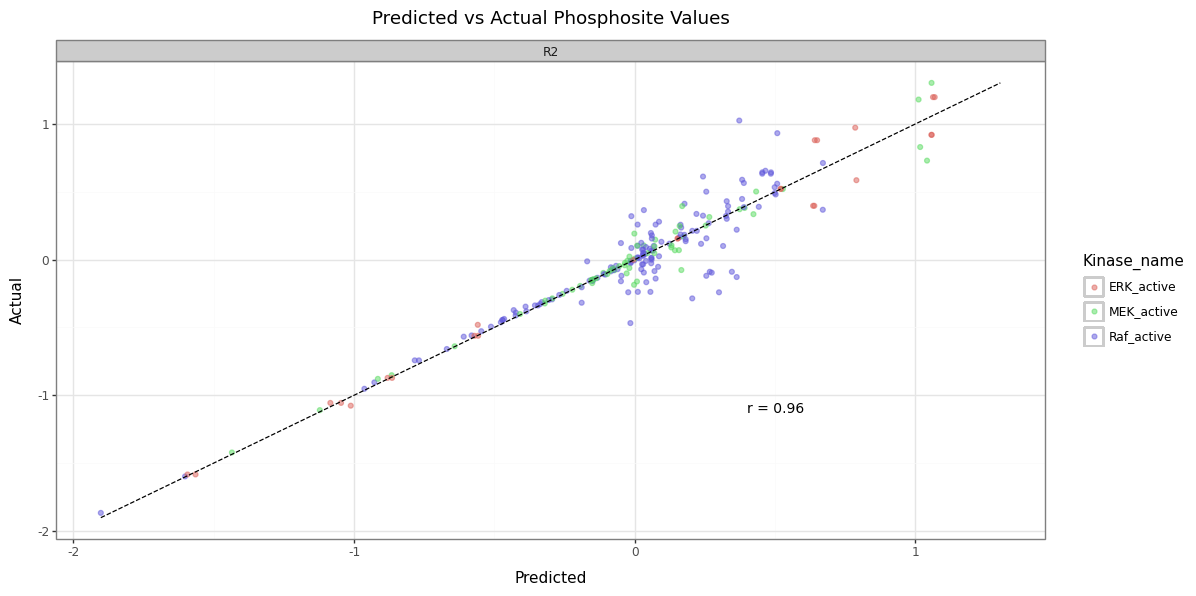

In [16]:
# Evaluate the trained model
phosphosite_mapper.eval()
with torch.no_grad():
    Y_pred = phosphosite_mapper(X_kinases)


# Benchmarking subtract the mean time point value from all time points to center the data around zero
Y_pred = Y_pred - Y_pred.mean(dim=1, keepdim=True)
Y_actual = Y_actual - Y_actual.mean(dim=1, keepdim=True)

y_pred_np = Y_pred.detach().cpu().numpy()
y_actual_np = Y_actual.detach().cpu().numpy()

scatter_data = []

for rep_idx, replicate in enumerate(replicates):
    for time_idx, time_point in enumerate(time_points):
        for site_idx, site_name in enumerate(phosphosite_names):
            # Determine which kinase this site belongs to
            kinase_assignment = "Unknown"
            for kinase in kinase_names:
                if mapping_mask.loc[site_name, kinase] == 1:
                    kinase_assignment = kinase
                    break
                    
            scatter_data.append({
                'Predicted': y_pred_np[rep_idx, time_idx, site_idx],
                'Actual': y_actual_np[rep_idx, time_idx, site_idx],
                'Replicate': replicate,
                'Time': time_point,
                'Site': site_name,
                'Kinase_name': kinase_assignment  # Changed from 'Kinase' to 'Kinase_name'
            })

scatter_df = pd.DataFrame(scatter_data)

print(f"Scatter dataframe sample:")
print(scatter_df.head())
print(f"Columns in scatter_df: {scatter_df.columns.tolist()}")

correlations = []
for rep in replicates:
    rep_data = scatter_df[scatter_df['Replicate'] == rep]
    r, p = pearsonr(rep_data['Predicted'], rep_data['Actual'])
    correlations.append({'Replicate': rep, 'r': round(r, 2)})
    print(f"Replicate {rep}: Pearson r = {r:.4f}")

corr_df = pd.DataFrame(correlations)
corr_df['label'] = corr_df.apply(lambda row: f"r = {row['r']:.2f}", axis=1)

min_val = min(scatter_df['Predicted'].min(), scatter_df['Actual'].min())
max_val = max(scatter_df['Predicted'].max(), scatter_df['Actual'].max())
line_df = pd.DataFrame({'x': [min_val, max_val], 'y': [min_val, max_val]})

p = (
    p9.ggplot(scatter_df) +
    p9.geom_point(p9.aes(x='Predicted', y='Actual', color=scatter_df.columns[5]), alpha=0.5) +  # Use column by index
    p9.geom_line(data=line_df, mapping=p9.aes(x='x', y='y'), color='black', linetype='dashed') +
    p9.facet_wrap('~ Replicate') +
    p9.geom_text(
        data=corr_df,
        mapping=p9.aes(x=min_val + 0.75*(max_val-min_val), y=min_val + 0.25*(max_val-min_val), label='label'),
        size=10
    ) +
    p9.labs(title='Predicted vs Actual Phosphosite Values', x='Predicted', y='Actual') +
    p9.theme_bw() +
    p9.theme(figure_size=(12, 6))
)

p.draw()

Selected sites for time series plot: ['BRAF:P15056:S151s', 'BRAF:P15056:S335s', 'MP2K1:Q02750:S299s', 'MP2K1:Q02750:T386t', 'MK01:P28482:T185t', 'MK01:P28482:Y187y']


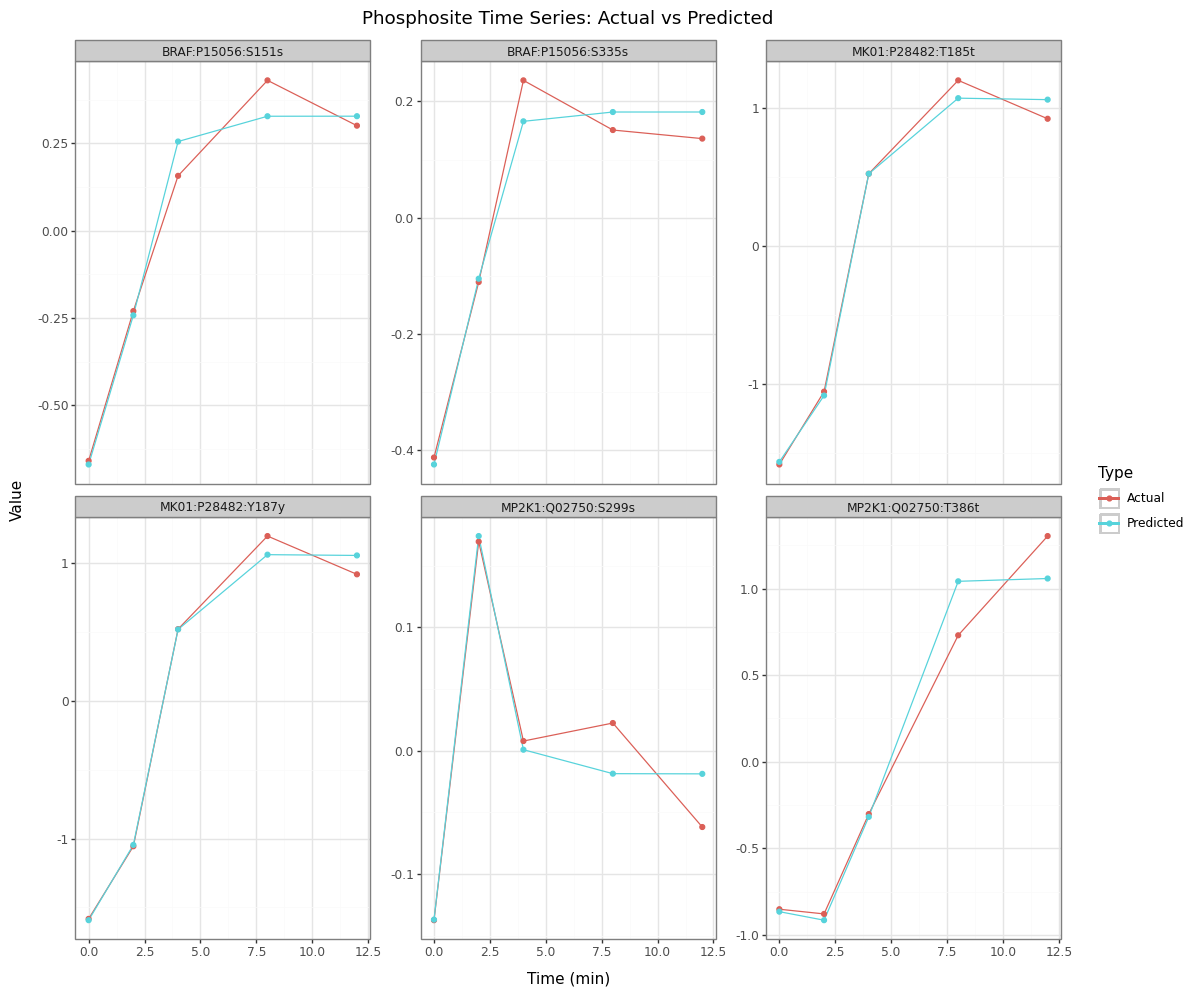

In [ ]:
selected_sites = {
    'Raf': [site for site in phosphosite_names if 'P15056' in site][:2],  # First 2 BRAF sites
    'MEK': [site for site in phosphosite_names if 'Q02750' in site][:2],  # First 2 MEK1 sites
    'ERK': [site for site in phosphosite_names if 'P28482' in site][:2]   # First 2 ERK2 sites
}

selected_sites_list = [site for sublist in selected_sites.values() for site in sublist]
print(f"Selected sites for time series plot: {selected_sites_list}")

ts_data = []

for rep_idx, replicate in enumerate(replicates):
    for site_name in selected_sites_list:
        site_idx = phosphosite_names.index(site_name)
        
        # Find which kinase this site belongs to
        kinase_assignment = "Unknown"
        for kinase, sites in selected_sites.items():
            if site_name in sites:
                kinase_assignment = kinase
                break
        
        # Add actual values
        for time_idx, time_point in enumerate(time_points):
            ts_data.append({
                'Time': time_point,
                'Value': y_actual_np[rep_idx, time_idx, site_idx],
                'Type': 'Actual',
                'Replicate': replicate,
                'Site': site_name,
                'Kinase': kinase_assignment
            })
            
        # Add predicted values
        for time_idx, time_point in enumerate(time_points):
            ts_data.append({
                'Time': time_point,
                'Value': y_pred_np[rep_idx, time_idx, site_idx],
                'Type': 'Predicted',
                'Replicate': replicate,
                'Site': site_name,
                'Kinase': kinase_assignment
            })


ts_df = pd.DataFrame(ts_data)

p_ts = (
    p9.ggplot(ts_df, p9.aes(x='Time', y='Value', color='Type', group='Type')) +
    p9.geom_line() +
    p9.geom_point() +
    p9.facet_wrap('Site', scales="free_y") +
    p9.labs(title='Phosphosite Time Series: Actual vs Predicted', x='Time (min)', y='Value') +
    p9.theme_bw() +
    p9.theme(figure_size=(12, 10))
)

p_ts.draw()